# **Trabalho Final: Disciplina Machine Learning. DCC-UFMG**

## **Aluno:** Gustavo Henrique Pereira Godinho

---

<p style = 'text-align: justify;'> Esse é o trabalho final da disciplina de Aprendizado de Máquina. O objetivo desse trabalho é aplicar as técnicas de Machine Learning que aprendemos em aula em um conjunto de dados, buscar pelos hiperparâmtros que maximizam o desempenho do modelo em observações não-vistas, avaliar e interpretar os resultados.</p>

Link para acesso do vídeo: https://youtu.be/zTNQFKwNxTg

### **Descrição do problema**


O conjunto de dados que será usado nesse estudo serão as partidas de futebol masculino e profissional ocorridas no Brasil entre os anos de 2009 até 2019. Os dados foram extraídos por meio de crawler no site http://www.ogol.com.br. O objetivo desse estudo usando esse conjunto de dados é usar as características das equipes pré-partida para tentar estimar o resultado ao final do jogo, ou seja, um problema de classificação, já que os resultados podem ser: **vitória do mandante**, **empate** ou **vitória do visitante**. Sendo o mandante a equipe que é a responsável por propiciar as condições de local para a realização da partida, quase sempre essa equipe joga em um estádio em sua cidade e com a maioria da torcida à seu favor. Já o visitante é a equipe que geralmente joga fora do seu estádio padrão e que não possui ou possui poucos torcedores para apoiá-la durante o confronto.
<br><br>
Essa é uma tarefa muito complexa porque o resultado de uma partida de futebol depende de vários fatores e NÃO PODE ser previsto com certeza antes da realização da partida. Isso porque os eventos que acontecem durante o jogo são determinantes para o resultado final. **Por exemplo:** suponha que as equipes **A** e **B** de qualidade igual vão jogar em um estádio que ambos conheçam bem e sem público, de modo que não há mandante ou visitante para a partida. É natural que imaginemos um valor de probabilidade de vitória igual a cada uma das equipes antes do início do duelo. No entanto, imagine que no primeiro minuto de jogo aconteça uma ação importante na partida, como um gol de uma das equipes ou a expulsão de um dos jogadores. Querendo ou não, as probabilidades iniciais dos resultados se alteraram em favor da equipe que lidera o placar ou aquela que agora tem mais jogadores em campo, mesmo com as características das equipes medidas antes da partida se mantendo iguais. 
<br><br>
Entender que o resultado final da partida depende do histórico pré-jogo das equipes mas muito também do que acontece durante o jogo nos dá dimensão do problema e ciente de que tendo somente as variáveis antes do confronto começar não nos dá conhecimento total do processo que leva a uma equipe ganhar, empatar ou perder. Além disso, existe o fator sorte associado a qualquer esporte. Levando tudo isso em consideração, temos uma realidade de que os modelos não terão taxa de acertos muito altas, o objetivo aqui é tentar mostrar as técnicas aprendidas na disciplina e tentar reduzir alguns problemas típicos em predição de resultados em jogos de futebol. Um objetivo auxiliar é tentar identificar quais são as covariáveis pré-jogo que mais influenciam no resultado da partida.
<br><br>
Resultado partida = $\alpha \mbox{[histórico equipes]} + \beta\mbox{[ações na partida]}$
<br>
<br>
Os valores de $\alpha$ e $\beta$ são desconhecidos, mas pelo que conhecemos do problema, geralmente $\beta$ é maior que $\alpha$.


### **Os Desafios relacionados à Viés e Variância**

Como vimos na disciplina, há dois tipos de erros em Aprendizado de Máquina. O de viés e de variância. Basicamente: o erro de viés acontece quando o modelo é simples demais para os dados e então não capta todas as particularidades existentes nos dados, por exemplo: estimar sempre a classe de maior proporção para todos as observações. Já o erro de variância acontece quando observações com características muito parecidas (covariáveis) levam a estimativas totalmente diferentes. 
<br><br>
Eu já investigo o problema de predição de resultados em futebol há algum tempo e como será mostrado mais à frente, a tarefa de tentar prever resultados de partidas de futebol possui sempre o problema de erro de viés dos modelos. Veremos que aproximadamente 50% das partidas terminam com **vitória do mandante**, só que os modelos estimam 95%-99% das novas observações nessa categoria, o que é muito ruim, já que se for pra prever tudo na mesma categoria, não é necessário ter modelo.
<br><br>
O problema de variância é parte das partidas de futebol. Jogos com as mesmas características (covariáveis) antes das partidas, levam a resultados diferentes, seja por acontecimentos durante as partidas ou até mesmo pela aleatoriedade envolvida nesses eventos esportivos.

### **Importando os pacotes**

Os pacotes necessários para a investigação do problema e busca pelo melhor algoritmo para tentar ajudar a elucidá-lo são: *pandas* (manipulação de dados tabulares), *numpy* (manipulação algébrica), o *matplotlib* para produção de gráficos e o *sklearn* para execução de diversos classificadores, busca de hiperparâmetros e pré-processamento dos dados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

### **Leitura dos dados** 

Realizando a leitura dos dados, a descrição das variáveis e algumas análises exploratórias para detalhar o que há nesses dados.

In [2]:
df_partidas = pd.read_csv('https://raw.githubusercontent.com/gustavohpgodinho/ml_trabalho_final/main/partidas.csv', sep = '|', encoding = "utf8", na_values = '')

In [3]:
df_partidas

,campeonato,divisao,temporada,rodada,data,hora,mandante,placar_final,visitante,resultado_final,...,semvitman,semvitvis,semempman,semempvis,vitsegman,vitsegvis,empsegman,empsegvis,dersegman,dersegvis
1,Campeonato Capixaba,1.0,2009,1F,2009-01-10,17h00,Colatinense,0-4,GEL,A,...,1,0,0,0,0,0,1,0,0,0
2,Campeonato Cearense,1.0,2009,1F,2009-01-10,NaN,Ferroviario,0-3,Horizonte,A,...,3,3,0,0,0,0,1,1,0,0
3,Campeonato Capixaba,1.0,2009,1F,2009-01-10,16h00,Serra,2-1,Rio Bananal,H,...,2,1,13,3,0,0,0,0,2,1
4,Campeonato Capixaba,1.0,2009,1F,2009-01-10,18h00,Linhares,1-2,Sao Mateus,A,...,9,0,2,0,0,0,0,0,2,0
5,Campeonato Pernambucano,1.0,2009,1F,2009-01-10,NaN,Sport,4-0,Vitoria das Tabocas,H,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42967,Campeonato Paraibano,1.0,2021,F,2021-06-17,16h00,Campinense,1-0,Sousa,H,...,2,0,0,5,0,5,2,0,0,0
42968,Campeonato Paraibano,1.0,2021,F,2021-06-20,10h00,Sousa,0-0,Campinense,D,...,1,0,6,1,0,1,0,0,1,0
42969,Campeonato Potiguar,1.0,2021,F,2021-06-23,21h15,ABC,1-1,Globo,D,...,2,0,1,3,0,2,0,0,1,0
42970,Campeonato Rondoniense,1.0,2021,F,2021-07-07,15h30,Porto Velho,1-1,Real Ariquemes,D,...,1,0,7,12,0,1,0,0,1,0


Como dito os dados foram colhidos do site ogol, o crawler, o cálculo das variáveis númericas de desempenho e histórico das equipes foram calculadas no software R, porque eu tenho mais familiaridade por lá. Esses dados se referem a partidas de futebol masculino profissional realizadas no Brasil nesse período, exceto a série D do Brasileirão e as séries que não a principal dos campeonatos estaduais. No site falta edições de alguns campeonatos estaduais, até por isso eu não vou usar todas essas partidas para treinar os classificadores. Os dados foram colhidos desde 2006, mas como há variáveis que medem desempenho histórico, eu retirei do conjunto de dados todas as partidas que aconteceram antes de 2009, supondo que o período de 2006 ao final de 2008 foi para ajustar essas variáveis ao desempenho das equipes.



### **Descrição das variáveis do conjunto de dados**

Abaixo a descrição das variáveis contidas na tabela de dados. As variáveis de detalhes das partidas que estão no site do ogol ou que eu calculei mas sem usar do histórico das equipes estão nas primeiras colunas. Já as variáveis numéricas que representam o histórico das equipes em diversas vertentes estão nas colunas finais.

*   **campeonato**: campeonato ou competição em que a partida foi disputada.
*   **divisao**: divisão do campeonato em que a partida foi disputada, quando isso se aplica, para uma mesma competição, quanto menor o valor dessa variável teoricamente é maior o nível técnico das equipes da competição.
*   **temporada**: temporada do campeonato em que a partida ocorreu, geralmente a temporada é o ano em que a partida ocorreu, mas pode acontecer da temporada se alongar até o ano seguinte, como ocorreu com o Brasileirão 2020 após a parada por conta da pandemia vigente do coronavírus.
*   **rodada**: rodada ou fase do campeonato ou competição em que a partida ocorre.
*   **data**: data em que a partida foi realizada.
*   **hora**: hora do dia em que a partida começou.
*   **mandante**: nome da equipe mandante envolvida na partida.
*   **placar_final**: placar ao fim da partida, sempre da forma: (inteiro não-negativo - inteiro não-negativo) que representa o número de gols feitos pela equipe mandante e o número de gols feitos pela equipe visitante, respectivamente.
*   **visitante**: nome da equipe visitante envolvida na partida. Necessariamente diferente da equipe mandante.
*   **resultado_final**: variável-alvo do problema de classificação. Essa variável pode assumir três valores: **'H'** se o mandante venceu a partida, **'D'** se a partida terminou empatada e **'A'** se o visitante venceu a partida. Essas letras vem de Home, Draw e Away.
*   **placar_parcial**: placar da forma da variável placar_final mas que reflete o placar no momento do intervalo da partida.
*   **resultado_parcial**: resultado da partida (H, D, A) quando as equipes foram para o intervalo.
*   **placar_75min**: placar da forma da variável placar_final mas que reflete o placar que a partida tinha aos 30 minutos do segundo tempo, quando 5/6 da partida já foi jogada.
*   **resultado_75min**: resultado da partida (H, D, A) quando a partida tinha aos 30 minutos do segundo tempo.
*   **publico**: número de torcedores presentes no estádio durante a realização da partida.
*   **estadio**: estádio em que a partida foi jogada.
*   **link_partida**: link do site do ogol onde as informações das partidas foram extraídas.
*   **ind_mandante_casa**: indicativo que o mandante realmente jogou em casa.
*   **ind_visitante_casa**: indicativo que o visitante realmente jogou fora de casa.

**Possíveis candidatas a covariáveis**

*   **elo_mandante_pesogols**: medida de desempenho dos resultados das equipes jogando em casa ponderada pelos gols marcados e sofridos por elas. Essa variável é calculada com base nos resultados anteriores da equipe nas partidas dela como mandante e teoricamente quanto maior, melhor é a equipe jogando em casa.
*   **elo_visitante_pesogols**: medida de desempenho dos resultados das equipes jogando fora de casa ponderada pelos gols marcados e sofridos por elas. Essa variável é calculada com base nos resultados anteriores da equipe nas partidas dela como visitantes e teoricamente quanto maior, melhor é a equipe fora de casa.
*   **difelo_pesogols**: variável elo_mandante_pesogols subtraída pela variável elo_visitante_pesogols. Se positiva elo_mandante_peso_gols é maior que o elo_visitante_pesogols, se negativa o contrário ocorre.
*   **elo_mandante**: medida de desempenho dos resultados das equipes jogando em casa mas sem ponderação dos gols que aconteceram nas partidas. Para essa variável não faz diferença se a equipe venceu por 1-0 ou por 7-1, o impacto no aumento do placar no aumento/diminuição dessa variável é o mesmo, independente do placar. Essa variável é calculada com base nos resultados anteriores da equipe nas partidas dela como mandante e teoricamente quanto maior, melhor é a equipe jogando em casa.
*   **elo_visitante**: medida de desempenho dos resultados das equipes jogando fora de casa mas sem ponderação dos gols que aconteceram nas partidas. Assim como a variável elo_mandante, não faz diferença o placar da partida para aumento ou diminuição dos valores dessa variável para determinada equipe, tudo que importa é o placar. Essa variável é calculada com base nos resultados anteriores da equipe nas partidas dela como visitante e teoricamente quanto maior, melhor é a equipe jogando fora de casa.
*   **apr_mandante**: variável que tem limite entre 0 e 3 e que reflete a média de número de pontos ganhos pela equipe que está como mandante nas suas últimas 10 partidas como mandante. Quanto maior, melhor foi o desempenho da equipe nas suas últimas 10 partidas em casa.
*   **apr_visitante**: variável que tem limite entre 0 e 3 e que reflete a média de número de pontos ganhos pela equipe que está como visitante nas suas últimas 10 partidas como visitante. Quanto maior, melhor foi o desempenho da equipe nas suas últimas 10 partidas fora de casa.
*   **difpontos**: variável apr_mandante subtraída pela variável apr_visitante.
*   **mm10_gfm**: média móvel do número de gols feitos pela equipe mandante nas suas últimas 10 partidas como mandante.
*   **mm10_gsm**: média móvel do número de gols sofridos pela equipe mandante nas suas últimas 10 partidas como mandante.
*   **mm10_gsv**: média móvel do número de gols sofridos pela equipe visitante nas suas últimas 10 partidas como visitante.
*   **mm10_gfv**: média móvel do número de gols feitos pela equipe visitante nas suas últimas 10 partidas como visitante.
*   **mm05_gfm**: média móvel do número de gols feitos pela equipe mandante nas suas últimas 5 partidas como mandante.
*   **mm05_gsm**: média móvel do número de gols sofridos pela equipe mandante nas suas últimas 5 partidas como mandante.
*   **mm05_gsv**: média móvel do número de gols sofridos pela equipe visitante nas suas últimas 5 partidas como visitante.
*   **mm05_gfv**: média móvel do número de gols feitos pela equipe visitante nas suas últimas 5 partidas como visitante.
*   **difelo**: variável elo_mandante subtraída pela variável elo_visitante. Se positiva elo_mandante é maior que o elo_visitante, se negativa o contrário ocorre.
*   **vitsegmancasa**: número de vitórias seguidas até aquela partida do mandante jogando em casa.
*   **empsegmancasa**: número de empates seguidos até aquela partida do mandante jogando em casa.
*   **dersegmancasa**: número de derrotas seguidas até aquela partida do mandante jogando em casa.
*   **semdermancasa**: número de jogos seguidos sem derrotas até aquela partida do mandante jogando em casa.
*   **semvitmancasa**: número de jogos seguidos sem vitórias até aquela partida do mandante jogando em casa.
*   **vitsegvisfora**: número de vitórias seguidas até aquela partida do visitante jogando fora de casa.
*   **empsegvisfora**: número de empates seguidos até aquela partida do visitante jogando fora de casa.
*   **dersegvisfora**: número de derrotas seguidas até aquela partida do visitante jogando fora de casa.
*   **semdervisfora**: número de jogos seguidos sem derrotas até aquela partida do visitante jogando fora de casa.
*   **semvitvisfora**: número de jogos seguidos sem vitórias até aquela partida do visitante jogando fora de casa.
*   **semderman**: número de jogos seguidos sem derrotas até aquela partida do mandante independente do mando de campo. 
*   **semdervis**: número de jogos seguidos sem derrotas até aquela partida do visitante independente do mando de campo.
*   **semvitman**: número de jogos seguidos sem vitórias até aquela partida do mandante independente do mando de campo. 
*   **semvitvis**: número de jogos seguidos sem vitórias até aquela partida do visitante independente do mando de campo.
*   **semempman**: número de jogos seguidos sem empates até aquela partida do mandante independente do mando de campo.
*   **semempvis**: número de jogos seguidos sem empates até aquela partida do visitante independente do mando de campo.
*   **vitsegman**: número de vitórias seguidas até aquela partida do mandante independente do mando de campo.
*   **vitsegvis**: número de vitórias seguidas até aquela partida do visitante independente do mando de campo.
*   **empsegman**: número de empates seguidas até aquela partida do mandante independente do mando de campo.
*   **empsegvis**: número de empates seguidas até aquela partida do visitante independente do mando de campo.
*   **dersegman**: número de derrotas seguidas até aquela partida do mandante independente do mando de campo.
*   **dersegvis**: número de derrotas seguidas até aquela partida do visitante independente do mando de campo.

Para mais detalhes das variáveis elo, abaixo está o elo das principais equipes mineiras sem e com a consideração dos gols feitos por essas equipes durante as partidas ao longo do tempo. A linha em preto representa o elo do Clube Atlético Mineiro, a linha em azul representa o elo do Cruzeiro Esporte Clube e a linha verde representa o América Futebol Clube. Repare como o elo em casa do Atlético cresceu após a chegada de Ronaldinho Gaúcho e como o desempenho do Cruzeiro caiu após a publicação do programa Fantástico que denunciou indícios de corrupção no clube.

***imagens feitas no R por ser mais fácil de adicionar detalhes a figuras e coladas nesse notebook***



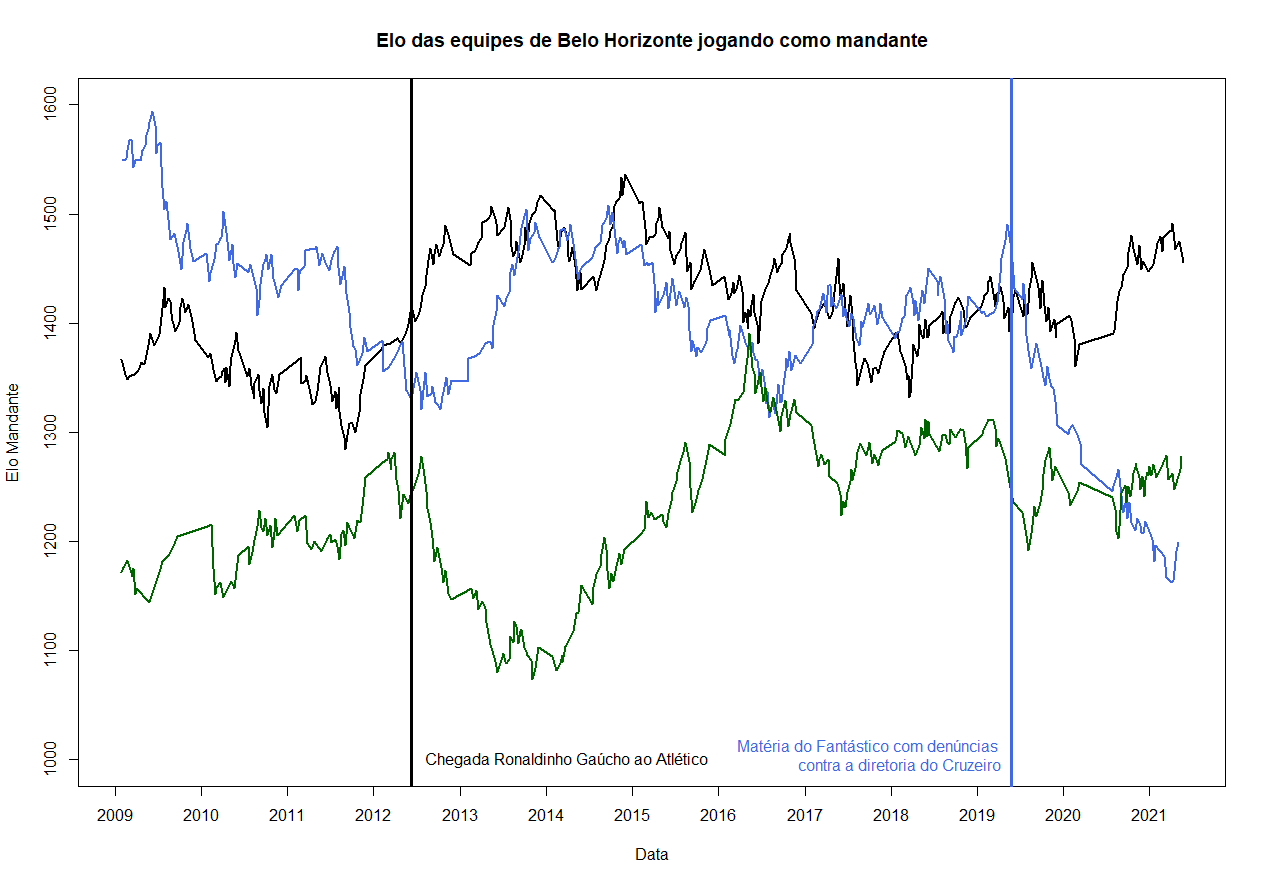

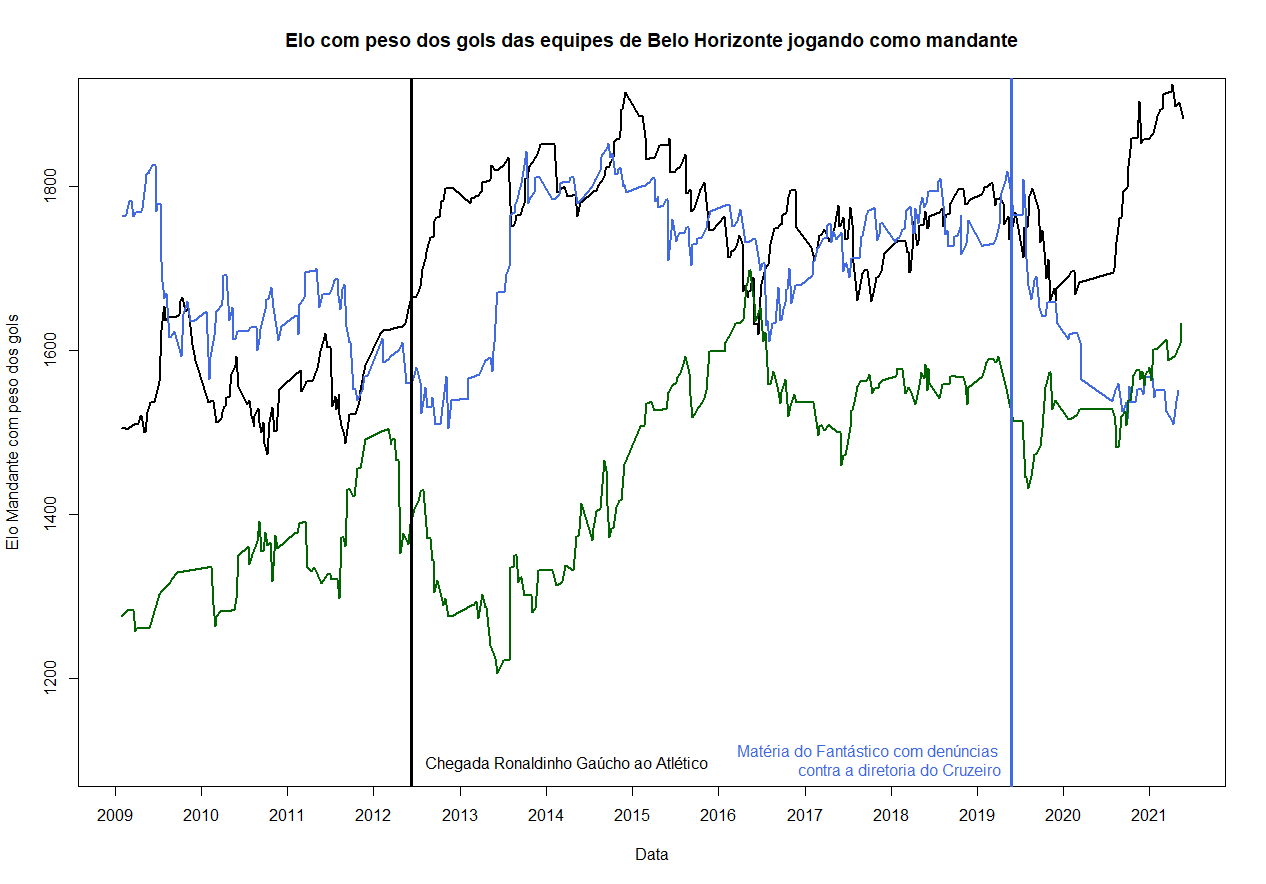

### **Divisao dos dados em treino e teste**

Eu não usarei todas as partidas que estão no dataframe. Isso porque o custo computacional ficaria muito grande e algumas equipes jogaram muito pouco e então algumas métricas ficariam distorcidas para elas, assim vou usar nos dados de treino e teste apenas os jogos entre as 50 equipes que mais ativas nesse período. Essas equipes são:

In [4]:
equipes_interesse = ["ABC", "America-MG", "America-RN", "ASA", "Athletico-PR", "Atletico-GO", "Atletico-MG", "Avai", "Bahia", "Boa Esporte", "Botafogo", "Botafogo-PB", 
                     "Bragantino", "Ceara", "Chapecoense", "Confianca", "Corinthians", "Coritiba", "CRB", "Criciuma", "Cruzeiro", "CSA", "Cuiaba", "Figueirense", "Flamengo", 
                     "Fluminense", "Fortaleza", "Goias", "Gremio", "Guarani", "Internacional", "Joinville", "Juventude", "Luverdense", "Nautico", "Oeste", "Palmeiras", 
                     "Parana", "Paysandu", "Ponte Preta", "Portuguesa", "Salgueiro", "Sampaio Correa", "Santa Cruz", "Santos", "Sao Paulo", "Sport", "Vasco", "Vila Nova", "Vitoria"]

Eu usarei as partidas entre 2009 e 2017 entre essas equipes para fazer o treino dos classificadores e a validação cruzada. Já as partidas entre 2018 e o fim de 2019 serão usadas para ver as estimativas do classificador final. Eu não usarei as partidas de 2020 e 2021 porque os resultados delas podem ter sido influenciados pela pandemia e a falta de torcida nos estádios.

In [5]:
df_partidas_20092017 = df_partidas[(df_partidas['mandante'].isin(equipes_interesse)) & (df_partidas['visitante'].isin(equipes_interesse)) & (df_partidas['temporada'].isin(range(2009, 2018)))]
df_partidas_20092017.index = range(df_partidas_20092017.shape[0])
df_partidas_20182019 = df_partidas[(df_partidas['mandante'].isin(equipes_interesse)) & (df_partidas['visitante'].isin(equipes_interesse)) & (df_partidas['temporada'].isin(range(2018, 2020)))]
df_partidas_20182019.index = range(df_partidas_20182019.shape[0])

In [6]:
df_partidas_20092017

,campeonato,divisao,temporada,rodada,data,hora,mandante,placar_final,visitante,resultado_final,...,semvitman,semvitvis,semempman,semempvis,vitsegman,vitsegvis,empsegman,empsegvis,dersegman,dersegvis
0,Campeonato Pernambucano,1.0,2009,1F,2009-01-14,NaN,Salgueiro,0-2,Sport,A,...,0,0,2,2,1,2,0,0,0,0
1,Campeonato Pernambucano,1.0,2009,1F,2009-01-17,NaN,Nautico,2-2,Salgueiro,D,...,0,1,1,3,1,0,0,0,0,1
2,Campeonato Catarinense,1.0,2009,1F,2009-01-18,17h00,Joinville,3-2,Criciuma,H,...,0,2,2,1,2,0,0,0,0,1
3,Campeonato Paulista,1.0,2009,R1,2009-01-21,19h30,Oeste,0-0,Ponte Preta,D,...,0,0,0,1,0,1,0,0,0,0
4,Campeonato Paulista,1.0,2009,R1,2009-01-21,21h30,Guarani,1-0,Portuguesa,H,...,0,6,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8088,Campeonato Brasileiro,1.0,2017,R38,2017-12-03,17h00,Vitoria,1-2,Flamengo,A,...,0,0,1,8,1,1,0,0,0,0
8089,Campeonato Brasileiro,1.0,2017,R38,2017-12-03,17h00,Atletico-GO,1-1,Fluminense,D,...,2,1,0,4,0,0,2,0,0,1
8090,Campeonato Brasileiro,1.0,2017,R38,2017-12-03,17h00,Atletico-MG,4-3,Gremio,H,...,1,0,0,1,0,1,1,0,0,0
8091,Campeonato Brasileiro,1.0,2017,R38,2017-12-03,17h00,Athletico-PR,3-0,Palmeiras,H,...,1,0,6,6,0,1,0,0,1,0


Abaixo há uma tabela com a frequência e proporção de cada uma dos resultados finais no conjunto de dados que vamos usar para o treinamento. Veja que a classe **'H'** (vitória do mandante) ocorre quase que o dobro das vezes que as outras duas classes.

In [7]:
df_tabela = pd.DataFrame(df_partidas_20092017['resultado_final'].value_counts())
df_tabela['prop'] = round(df_tabela['resultado_final']/sum(df_tabela['resultado_final']), ndigits = 8)
df_tabela


,resultado_final,prop
H,3997,0.493884
D,2168,0.267886
A,1928,0.238231


### **Relação entre o resultado parcial e o resultado final**

Saber o resultado no intervalo ajuda rezoavelmente saber o resultado ao fim do jogo. Das 8093 partidas do conjunto de treinamento, 7918 delas possuem a informação de resultado parcial. Veja que das 1884 (1009 + 742 + 133) vezes que o visitante venceu o jogo (A), 1009 dessas vezes, ou seja, 53,55% das vezes essas equipes já venciam no intervalo. Quando a partida terminou empatada (classe D) (2127 vezes), 1369 vezes (64,36%) a partida já estava empatada no intervalo. Quando o resultado final da partida foi a vitória do mandante (H): 3907 vezes, o mandante já vencia no intervalo em 2273 vezes (58,17%).


In [8]:
pd.DataFrame(confusion_matrix(y_true = df_partidas_20092017.dropna(subset=['resultado_parcial'])['resultado_final'], 
                              y_pred = df_partidas_20092017.dropna(subset=['resultado_parcial'])['resultado_parcial'], labels = ['A', 'D', 'H']), 
             columns = ['A', 'D', 'H'], index = ['A', 'D', 'H'])

,A,D,H
A,1009,742,133
D,336,1369,422
H,206,1428,2273


Uma outra interpretação dessa tabela é mais interessante. São elas: quando o resultado parcial é a vitória do visitante (A), quais as chances de cada uma das classes ao final da partida?

$P(\mbox{resultado final} = H |\mbox{resultado parcial}= A) = \frac{206}{1009 + 336 + 209} = 0,1328$ <br><br>
$P(\mbox{resultado final} = D |\mbox{resultado parcial}= A) = \frac{336}{1009 + 336 + 209} = 0,2166$ <br><br>
$P(\mbox{resultado final} = A |\mbox{resultado parcial}= A) = \frac{1009}{1009 + 336 + 209} = 0,6505$ <br><br>

---
$P(\mbox{resultado final} = H |\mbox{resultado parcial}= D) = \frac{1428}{742 + 1369 + 1428} = 0,4035$ <br><br>
$P(\mbox{resultado final} = D |\mbox{resultado parcial}= D) = \frac{1369}{742 + 1369 + 1428} = 0,3868$ <br><br>
$P(\mbox{resultado final} = A |\mbox{resultado parcial}= D) = \frac{742}{742 + 1369 + 1428} = 0,2096$ <br><br>

---
$P(\mbox{resultado final} = H |\mbox{resultado parcial}= H) = \frac{2273}{133 + 422 + 2273} = 0,8037$ <br><br>
$P(\mbox{resultado final} = D |\mbox{resultado parcial}= H) = \frac{422}{133 + 422 + 2273} = 0,1492$ <br><br>
$P(\mbox{resultado final} = A |\mbox{resultado parcial}= H) = \frac{133}{133 + 422 + 2273} = 0,0470$ <br><br>

O que essas informações mostram é que sabendo que a partida chegou no intervalo com vitória do visitante (A), o resultado mais provável para o fim da partida é também (A) com 65,05% de chance de ocorrer. 

Quando a partida chegou empatada (D) no intervalo, o resultado mais provável para o fim da partida é vitória do mandante (H), com probabilidade igual a 40,35%.

Já quando o resultado parcial da partida é igual a vitória do mandante (H), o mais provável é que essa equipe também termine como vencedora da partida, com probabilidade de 80,37%.

A acurácia de prever o resultado mais provável a partir do intervalo como resultado final da partida é igual a $1009 + 1428 + 2273$ dividido por 7918, que é igual a 59,48%.


### **Relação entre o resultado aos 75 minutos e o resultado final**

Se sabendo o resultado parcial já nos ajuda a prever o resultado final da partida, saber o resultado aos 75 minutos, quando aproximadamente 5/6 da partida já foi jogado deve nos ajudar mais. Vamos checar a tabela cruzada:

In [9]:
pd.DataFrame(confusion_matrix(y_true = df_partidas_20092017.dropna(subset=['resultado_75min'])['resultado_final'], 
                              y_pred = df_partidas_20092017.dropna(subset=['resultado_75min'])['resultado_75min'], labels = ['A', 'D', 'H']), 
             columns = ['A', 'D', 'H'], index = ['A', 'D', 'H'])

,A,D,H
A,1481,367,36
D,267,1535,325
H,57,575,3275


As probabilidades dos resultados ao final da partida, condicionada ao resultado aos 75 minutos são:

$P(\mbox{resultado final} = H |\mbox{resultado 75min}= A) = \frac{36}{1481 + 267 + 57} = 0,0199$ <br><br>
$P(\mbox{resultado final} = D |\mbox{resultado 75min}= A) = \frac{267}{1481 + 267 + 57} = 0,1479$ <br><br>
$P(\mbox{resultado final} = A |\mbox{resultado 75min}= A) = \frac{1481}{1481 + 267 + 57} = 0,8204$ <br><br>

---
$P(\mbox{resultado final} = H |\mbox{resultado 75min}= D) = \frac{575}{367 + 1535 + 575} = 0,2321$ <br><br>
$P(\mbox{resultado final} = D |\mbox{resultado 75min}= D) = \frac{1535}{367 + 1535 + 575} = 0,6197$ <br><br>
$P(\mbox{resultado final} = A |\mbox{resultado 75min}= D) = \frac{367}{367 + 1535 + 575} = 0,1481$ <br><br>

---
$P(\mbox{resultado final} = H |\mbox{resultado 75min}= H) = \frac{3275}{36 + 325 + 3275} = 0,9007$ <br><br>
$P(\mbox{resultado final} = D |\mbox{resultado 75min}= H) = \frac{325}{36 + 325 + 3275} = 0,0893$ <br><br>
$P(\mbox{resultado final} = A |\mbox{resultado 75min}= H) = \frac{36}{36 + 325 + 3275} = 0,0099$ <br><br>

A acurácia de prever como o resultado aos 75 minutos como o resultado final da partida é igual a 1481 + 1535 + 3275 dividido por 7918, que é igual a 79,45%.

### **Seleção de covariáveis importantes**

Aqui estão todas as covariáveis numéricas de desempenho/histórico das equipes, elas são 39 ao todo. Naturalmente algumas delas não influenciam em nada no resultado da partida e só vão onerar o processo de estimação dos parâmetros. 

In [10]:
lst_covariaveis0 = ['elo_mandante_pesogols', 'elo_visitante_pesogols', 'difelo_pesogols', 'elo_mandante', 
                    'elo_visitante', 'apr_mandante', 'apr_visitante', 'difpontos', 'mm10_gfm', 'mm10_gsm', 
                    'mm10_gsv', 'mm10_gfv', 'mm05_gfm', 'mm05_gsm', 'mm05_gsv', 'mm05_gfv', 'difelo', 
                    'vitsegmancasa', 'empsegmancasa', 'dersegmancasa', 'semdermancasa', 'semvitmancasa', 
                    'vitsegvisfora', 'empsegvisfora', 'dersegvisfora', 'semdervisfora', 'semvitvisfora', 
                    'semderman', 'semdervis', 'semvitman', 'semvitvis', 'semempman', 'semempvis', 
                    'vitsegman', 'vitsegvis', 'empsegman', 'empsegvis', 'dersegman', 'dersegvis']

O que eu vou fazer para tentar reduzir o grande número de covariáveis é executar um adaboost com 1000 iterações e verificar quais são as covariáveis mais importantes para fazer o treino dos outros algoritmos.

In [11]:
clf_auxiliar = AdaBoostClassifier(algorithm = 'SAMME', n_estimators = 1000)
clf_auxiliar.fit(X = df_partidas_20092017[lst_covariaveis0], y = df_partidas_20092017['resultado_final'])

pd.DataFrame({'covariaveis': lst_covariaveis0, 
              'importancia': clf_auxiliar.feature_importances_}).sort_values('importancia', ascending = False)

,covariaveis,importancia
16,difelo,0.208366
2,difelo_pesogols,0.171743
4,elo_visitante,0.108817
18,empsegmancasa,0.106809
1,elo_visitante_pesogols,0.102533
21,semvitmancasa,0.048679
3,elo_mandante,0.041836
6,apr_visitante,0.030107
7,difpontos,0.027425
28,semdervis,0.022879


Eu irei usar somente as covariáveis que tiveram explicações maior que 1/39 (0,0256), já que essas são as que explicam mais do que a proporção delas. Essas serão as covariáveis usadas no treinamento dos diversos classificadores que serão estudados nesse trabalho.

In [12]:
lst_covariaveis = ['difelo', 'difelo_pesogols', 'elo_visitante', 'empsegmancasa', 
                   'elo_visitante_pesogols', 'semvitmancasa', 'elo_mandante', 
                   'apr_visitante', 'difpontos']

In [13]:
df_partidas_20092017[lst_covariaveis]

,difelo,difelo_pesogols,elo_visitante,empsegmancasa,elo_visitante_pesogols,semvitmancasa,elo_mandante,apr_visitante,difpontos
0,-287.102055,-365.499157,1262.307871,0,1343.931006,4,975.205817,0.6,0.900000
1,316.533489,423.753170,1058.327639,1,1099.836100,1,1374.861128,1.2,0.400000
2,-25.843840,-2.871627,1099.092943,0,1175.410232,0,1073.249103,0.2,1.600000
3,-103.164065,-163.094645,1206.904187,0,1292.161561,0,1103.740122,0.5,0.630703
4,-11.246606,56.766363,1240.794054,0,1252.632331,0,1229.547448,0.3,2.000000
...,...,...,...,...,...,...,...,...,...
8088,-118.016553,-94.705039,1333.892204,1,1591.025096,1,1215.875651,1.1,-0.200000
8089,-103.424094,-28.006358,1267.213619,1,1499.833582,1,1163.789525,0.6,0.300000
8090,-17.149060,32.188930,1391.554195,0,1686.446296,0,1374.405135,1.5,0.300000
8091,-60.011443,-8.273612,1358.813873,0,1652.467474,0,1298.802430,1.5,0.300000


###  **Busca por hiperparâmetros e métricas para avaliação**
A busca pelos hiperparâmetros que aumentam o desempenho do modelo em dados não-vistos será feita através de busca por grid e avaliada através de validação cruzada com 5 folds, ou seja, estimação dos parâmetros em 4 folds e avaliação das estimativas no fold restante que não foi usado para a treinamento dos parâmetros. O(s) melhor(es) hiperparâmetro(s) para o algoritmo será(ão) aquele(s) que maximiza(m) a média do desempenho do algoritmo no fold de teste. 

O grande problema aqui é que o objetivo é ter a taxa de acertos o maior possível (acurácia alta), porém se essa acurácia for alta devido a prever todas as observações como **vitória do mandante**, não adianta nada. Por isso precisamos de uma métrica de avaliação que considere os acertos em cada uma das classes e o F1 score macro é ideal para isso, porque ele vai fazer a média entre precisão e revocação em cada uma das três classes e combiná-las nessa métrica que vai de 0 a 1. No entanto a acurácia ainda é importante e eu vou criar uma métrica hibrida que soma o f1_score médio e a acurácia média nos folds de teste para avaliar os classificadores. Assim o melhor classificador será aquele com hiperparâmetros com o bom f1_score_macro médio nos folds de teste mas que também acerta uma parte considerável das observações. Isso causa alguma confusão porque a acurácia e o f1_score não se relacionam muito em problemas de classe desbalanceadas, ou seja, o classificador com maior acurácia não será o classificador com melhor f1_score e o contrário também é verdade.

Abaixo vou criar uma função para adicionar essa métrica hibrida aos resultados do dataframe da validação cruzada:

In [85]:
def formata_cv_resultados(dicionario):
    colunas_fora = ['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split0_train_accuracy','split1_train_accuracy','split2_train_accuracy','split3_train_accuracy','split4_train_accuracy',
                    'split0_test_f1_macro', 'split1_test_f1_macro', 'split2_test_f1_macro', 'split3_test_f1_macro', 'split4_test_f1_macro',
                    'split0_train_f1_macro','split1_train_f1_macro','split2_train_f1_macro','split3_train_f1_macro','split4_train_f1_macro',
                    'std_fit_time', 'mean_score_time', 'std_score_time']
    
    df = pd.DataFrame(dicionario).drop(colunas_fora, axis = 1)
    df['soma'] = df['mean_test_accuracy'] + df['mean_test_f1_macro']
    df = df.sort_values('soma', ascending = False)
    
    return df

### **Classificador Naive Bayes**

O Naive Bayes será usado como o *baseline* do experimento, por isso não vou variar o hiperparâmetro do algoritmo que é o *var_smoothing*. Antes de ajustar o classificador, as covariáveis estão sendo padronizadas, deixando-as com média 0 e variância 1.

In [76]:
# APROXIMADAMENTE 1 SEGUNDO PARA EXECUTAR
# fluxo de tarefas a serem feitas com as covariáveis do conjunto de treinamento.
pipeline_naive_bayes = Pipeline(steps = [('padronizacao covariaveis', StandardScaler()), 
                                         ('naive_bayes', GaussianNB())])

# definição do hiperparametro usado nesse classificador, nesse caso estou definindo apenas como o valor default.
hiperparametro_naive_bayes = {'naive_bayes__var_smoothing': [1e-9]}

# arquitetura para busca do hiperparametro que maximiza o desempenho do algoritmo em teste. Nesse caso só 
# está sendo usado um hiperparâmetro. Logo, não há porque escolher o melhor, mas estou deixando assim apenas 
# para manter a estrutura para os próximos classificadores
clf_naive_bayes = GridSearchCV(
    estimator = pipeline_naive_bayes, param_grid = hiperparametro_naive_bayes, 
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 25031908),
    n_jobs = -1, scoring = ['accuracy', 'f1_macro'], 
    refit = 'f1_macro', return_train_score = True, verbose = True)

# treinamento dos dados atraves do naive bayes
clf_naive_bayes.fit(
    X = df_partidas_20092017[lst_covariaveis], 
    y = df_partidas_20092017['resultado_final'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25031908, shuffle=True),
             estimator=Pipeline(steps=[('padronizacao covariaveis',
                                        StandardScaler()),
                                       ('naive_bayes', GaussianNB())]),
             n_jobs=-1, param_grid={'naive_bayes__var_smoothing': [1e-09]},
             refit='f1_macro', return_train_score=True,
             scoring=['accuracy', 'f1_macro'], verbose=True)

O resultado da validação cruzada dos dados no Naive Bayes teve acurácia média no fold de teste igual à 46,78%, já a acurácia média nos folds de treino não foi muito maior: 46,94%. O valor médio do f1 score em teste é relativamente baixo: 35,49%.

In [81]:
formata_cv_resultados(clf_naive_bayes.cv_results_)
#pd.DataFrame(clf_naive_bayes.cv_results_)

,mean_fit_time,param_naive_bayes__var_smoothing,params,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,mean_train_f1_macro,std_train_f1_macro,soma
0,0.018667,1e-09,{'naive_bayes__var_smoothing': 1e-09},0.467811,0.015561,1,0.469418,0.002825,0.354998,0.026036,1,0.354291,0.010937,0.822809


As estatísticas de resumo das probabilidades estimadas das classes pelo Naive Bayes é dada abaixo. Veja que as probabilidades das classes variam muito, por exemplo: para a classe 'H' (**vitória do mandante**), o intervalo interquatílico das probabilidades é: [0,285; 0,701].

In [82]:
pd.DataFrame(clf_naive_bayes.predict_proba(df_partidas_20092017[lst_covariaveis]), columns = ['A', 'D', 'H']).describe().round(3)

,A,D,H
count,8093.000,8093.000,8093.000
mean,0.259,0.248,0.493
std,0.196,0.088,0.252
min,0.000,0.000,0.000
25%,0.101,0.188,0.285
50%,0.213,0.265,0.498
75%,0.378,0.316,0.701
max,1.000,0.451,0.996


Abaixo as previsões das classes feitas pelo Naive Bayes nas partidas do conjunto de treinamento e a matriz de confusão das previsões feitas pelo Naive Bayes. Veja que 67% das classificações foram feitas como **vitória do mandante** (H). Na matriz de confusão temos que menos de 1/3 das predições que o modelo fez nas classes A e D se confirmaram, 32,64% (742/total de predições na classe A) e 31,02% (112/total de predições na classe D).

In [17]:
df_tabela = pd.DataFrame(pd.DataFrame(clf_naive_bayes.predict(df_partidas_20092017[lst_covariaveis])).value_counts(), 
                         columns = ['classe'])
df_tabela['prop'] = round(df_tabela['classe']/sum(df_tabela['classe']), ndigits = 4)
df_tabela

,classe,prop
0,,
H,5459,0.6745
A,2273,0.2809
D,361,0.0446


In [18]:
pd.DataFrame(confusion_matrix(y_true = df_partidas_20092017['resultado_final'], 
                              y_pred = clf_naive_bayes.predict(df_partidas_20092017[lst_covariaveis]), labels = ['A', 'D', 'H']), 
             columns = ['pred_A', 'pred_D', 'pred_H'], index = ['real_A', 'real_D', 'real_H'])


,pred_A,pred_D,pred_H
real_A,742,74,1112
real_D,665,112,1391
real_H,866,175,2956


## **Classificador Regressão Logística**

A Regressão Logística será o próximo algoritmo a ser treinado. Aqui eu vou criar algumas covariáveis polinomiais de grau 2 e de interação entre covariáveis. Daí seguindo o fluxo de tarefas no processo de treinamento é executada a padronização das covariáveis para deixá-las com média 0 e variância 1. 
<br><br>
Os hiperparâmetros que serão variados serão o C que é um peso para regularização e o *class_weight* que é o peso das classes que serão testados sem peso de classes, pesos balanceados, ou seja, as classes **A** e **D** possuem aproximadamente 2 vezes mais peso que a classe **H** e também testei um super desbalanceamento com as classes **A** e **D** com peso 4 vezes maior que **H**.

In [98]:
# APROXIMADAMENTE 18 SEGUNDOS PARA EXECUTAR
# fluxo de tarefas a serem executadas as covariáveis do conjunto de treino
pipeline_reglog = Pipeline(steps = [('interacao variaveis', PolynomialFeatures(degree = 2)),
                                    ('padronizacao covariaveis', StandardScaler()),
                                    ('reglog', LogisticRegression(max_iter = 100))])

# o conjunto de candidatos a ser a melhor combinação de hiperparametros na regressão logistica
hiperparametros_reglog = {'reglog__C': [0.01, 1, 10], 
                          'reglog__class_weight': [None, 'balanced', {'H' : 1, 'D': 4, 'A': 4}]}

# arquitetando a busca por grid dos hiperparametros atraves de validação cruzada
clf_reglog = GridSearchCV(estimator = pipeline_reglog, param_grid = hiperparametros_reglog,
                          cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 25031908),
                          n_jobs = -1, scoring = ['accuracy', 'f1_macro'], refit = 'f1_macro', 
                          return_train_score = True, verbose = True)

# ajustando o algoritmo aos dados do nosso estudo
clf_reglog.fit(X = df_partidas_20092017[lst_covariaveis], y = df_partidas_20092017['resultado_final'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25031908, shuffle=True),
             estimator=Pipeline(steps=[('interacao variaveis',
                                        PolynomialFeatures()),
                                       ('padronizacao covariaveis',
                                        StandardScaler()),
                                       ('reglog', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'reglog__C': [0.01, 1, 10],
                         'reglog__class_weight': [None, 'balanced',
                                                  {'A': 4, 'D': 4, 'H': 1}]},
             refit='f1_macro', return_train_score=True,
             scoring=['accuracy', 'f1_macro'], verbose=True)

Abaixo há a representação dos resultados da validação cruzada da Regressão Logística com as várias configurações de hiperparâmetros. Os hiperparâmetros que levaram ao melhor resultado médio do f1_score no fold de teste foi a combinação de C igual a 0,01 (forte regularização) e peso balanceado das classes, apesar de essa não ser a configuração que leva a maior acurácia média em teste. A acurácia média nos folds de teste para a Regressão Logística com C igual a 0,01 e peso balanceado nas classes foi de 41,86%, já a acurácia média desse classificador nos folds de treino não foi muito maior: 42,70%. A maior média do f1_score nos folds de teste teve valor de 39,89%, cerca de 4% maior do que o achado no Naive Bayes.

In [99]:
formata_cv_resultados(clf_reglog.cv_results_).drop('params', axis = 1)

,mean_fit_time,param_reglog__C,param_reglog__class_weight,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,mean_train_f1_macro,std_train_f1_macro,soma
1,0.633079,0.01,balanced,0.418635,0.014614,4,0.427067,0.001649,0.390123,0.012659,1,0.398951,0.001695,0.808758
4,0.975426,1,balanced,0.418140,0.013509,5,0.429909,0.001850,0.390034,0.012130,2,0.403222,0.003393,0.808174
7,1.049631,10,balanced,0.416905,0.013260,6,0.429692,0.000969,0.389083,0.009951,3,0.403607,0.003147,0.805987
6,1.012044,10,None,0.494748,0.003794,2,0.500649,0.001211,0.289617,0.007583,4,0.296975,0.005472,0.784365
3,0.967380,1,None,0.494130,0.004205,3,0.500463,0.001588,0.286847,0.006099,5,0.295920,0.005999,0.780977
0,0.606074,0.01,None,0.495243,0.004583,1,0.497930,0.001647,0.276866,0.006256,6,0.280916,0.005997,0.772109
8,0.833778,10,"{'H': 1, 'D': 4, 'A': 4}",0.286423,0.012275,7,0.299518,0.001382,0.256785,0.012568,7,0.269716,0.002196,0.543207
5,0.947017,1,"{'H': 1, 'D': 4, 'A': 4}",0.286175,0.010324,8,0.299055,0.001937,0.255191,0.010331,8,0.268911,0.002250,0.541366
2,0.839392,0.01,"{'H': 1, 'D': 4, 'A': 4}",0.282592,0.012608,9,0.294483,0.002546,0.249753,0.011813,9,0.261512,0.003379,0.532345


Para avaliar se o modelo está bem treinado, abaixo estão as estatísticas de resumo das probabilidades estimadas das partidas do conjunto de treinamento em cada uma das classes para as partidas do conjunto de treinamento é dada abaixo. Veja que as probabilidades das classes possuem médias muito parecidas porque a melhor regressão logística balanceia as classes dando peso maior as classes menos frequentes. Assim, esse classificador dá probabilidades muito parecidas para cada uma das classes.

In [100]:
pd.DataFrame(clf_reglog.predict_proba(df_partidas_20092017[lst_covariaveis]), columns = ['A', 'D', 'H']).describe().round(3)

,A,D,H
count,8093.000,8093.000,8093.000
mean,0.329,0.332,0.339
std,0.076,0.035,0.089
min,0.084,0.121,0.074
25%,0.276,0.313,0.276
50%,0.324,0.336,0.331
75%,0.376,0.354,0.393
max,0.666,0.500,0.782


Abaixo as previsões feitas pela Regressão Logística com os hiperparâmetros que deram o maior valor de f1_score nos folds de teste e a matriz de confusão. Perceba que esse classificador abriu mão de ter uma acurácia maior prevendo quase todas as observações como **vitória do mandante** (classe H) para conseguir variar as previsões. 42% das partidas do treino foram previstas como vitória dos mandantes (H) e a taxa de acertos da regressão na classe 'A' foi de 31,50% (875/total de predições na classe A) e na classe 'D' foi de 30,20% (576/total de predições na classe D), resultados parecidos com o Naive Bayes.

In [111]:
df_tabela = pd.DataFrame(pd.DataFrame(clf_reglog.predict(df_partidas_20092017[lst_covariaveis])).value_counts(), 
                         columns = ['classe'])
df_tabela['prop'] = round(df_tabela['classe']/sum(df_tabela['classe']), ndigits = 4)
df_tabela

,classe,prop
0,,
H,3409,0.4212
A,2777,0.3431
D,1907,0.2356


In [102]:
pd.DataFrame(confusion_matrix(y_true = df_partidas_20092017['resultado_final'], 
                              y_pred = clf_reglog.predict(df_partidas_20092017[lst_covariaveis]), labels = ['A', 'D', 'H']), 
             columns = ['pred_A', 'pred_D', 'pred_H'], index = ['real_A', 'real_D', 'real_H'])

,pred_A,pred_D,pred_H
real_A,875,447,606
real_D,788,576,804
real_H,1114,884,1999


### **Classificador Regressão Logística sem peso nas classes**


Para verificar os problemas que é não colocar pesos nas classes, verifiquemos como são os resultados da melhor Regressão Logística sem peso nas classificações e com hiperparâmetro C igual a 10. Note na avaliação dos resultado da validação cruzada anterior que esse classificador teve acurácia média nos folds de teste igual a 49,47% mas f1_score médio em teste de apenas 28

In [106]:
# criando o fluxo de tarefas para serem feitas com as covariáveis.
clf_reglog1 = Pipeline(steps = [('interacao variaveis', PolynomialFeatures(degree = 2)),
                                ('padronizacao covariaveis', StandardScaler()),
                                ('reglog', LogisticRegression(max_iter = 1000, C = 10))])

# ajustando o algoritmo aos dados do nosso estudo
clf_reglog1.fit(X = df_partidas_20092017[lst_covariaveis], y = df_partidas_20092017['resultado_final'])

Pipeline(steps=[('interacao variaveis', PolynomialFeatures()),
                ('padronizacao covariaveis', StandardScaler()),
                ('reglog', LogisticRegression(C=10, max_iter=1000))])

O dataframe com as estatísticas de resumo das probabilidades previstas pela Regressão Logística sem considerar peso nas classes e com C igual a 10 para as observações no conjunto de treinamento está exibido abaixo. Notamos um comportamento parecido com o que aconteceu no Naive Bayes, a classe dominante **vitória do mandante** (H) ficou com probabilidade média maior que as classes minoritárias. É interessante ver também que o classificador conseguiu variar os valores das probabilidades para as partidas, o intervalo interquartílico para a classe H é de [0,427; 0,559], isso representa que 50% da frequência 
das probabilidades previstas para o classificador nesses dados caiu dentro desse intervalo.

In [114]:
pd.DataFrame(clf_reglog1.predict_proba(df_partidas_20092017[lst_covariaveis]), columns = ['A', 'D', 'H']).describe().round(3)

,A,D,H
count,8093.000,8093.000,8093.000
mean,0.238,0.268,0.494
std,0.074,0.048,0.099
min,0.041,0.060,0.129
25%,0.186,0.240,0.426
50%,0.231,0.269,0.490
75%,0.284,0.296,0.559
max,0.641,0.524,0.871


Abaixo temos a tabela com a frequência dos resultados previstos pelo classificador e também a matriz de confusão. Note que ele estimou mais de 91% das observações como **vitória do mandante** (classe H), o que é bastante ruim, no entanto, ele conseguiu taxa de acertos maiores nas classes minoritárias. Quando esse classificador previu o resultado da partida como **vitória do visitante** (classe A) em 40,87% das vezes realmente aconteceu uma vitória do visitante (206/total de predições na classe A) e quando o classificador previu o resultado da partida como **empate** (classe D) em 35,36% das vezes realmente foi empate (64/total de predições na classe D). Esses valores são ligeiramente melhores que a Regressão Logística considerando peso para balancear as classes.

In [112]:
df_tabela = pd.DataFrame(pd.DataFrame(clf_reglog1.predict(df_partidas_20092017[lst_covariaveis])).value_counts(), 
                         columns = ['classe'])
df_tabela['prop'] = round(df_tabela['classe']/sum(df_tabela['classe']), ndigits = 4)
df_tabela

,classe,prop
0,,
H,7413,0.9160
A,500,0.0618
D,180,0.0222


In [179]:
pd.DataFrame(confusion_matrix(y_true = df_partidas_20092017['resultado_final'], 
                              y_pred = clf_reglog1.predict(df_partidas_20092017[lst_covariaveis]), labels = ['A', 'D', 'H']), 
             columns = ['pred_A', 'pred_D', 'pred_H'], index = ['real_A', 'real_D', 'real_H'])

,pred_A,pred_D,pred_H
real_A,204,58,1666
real_D,131,63,1974
real_H,165,59,3773


## **Classificador Árvore de Decisão**

O próximo algoritmo a ser treinado é a Árvore de Decisão. Os hiperparâmetros que serão testados é a profundidade máxima da árvore e o peso de cada uma das classes, assim como foi feito para a regressão logística.

In [110]:
# APROXIMADAMENTE 37 SEGUNDOS PARA EXECUTAR
pipeline_arvore_decisao = Pipeline(steps= [('arvore_decisao', DecisionTreeClassifier(criterion = 'entropy'))])

# definindo os valores possiveis para o hiperparametro profundidade da árvore
hiperparametro_arvore_decisao = {'arvore_decisao__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                                 'arvore_decisao__class_weight': [None, 'balanced', {'H' : 1, 'D': 4, 'A': 4}]}

clf_arvore_decisao = GridSearchCV(estimator = pipeline_arvore_decisao, param_grid = hiperparametro_arvore_decisao, 
                                  cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 25031908),
                                  n_jobs = -1, scoring = ['accuracy', 'f1_macro'], refit = 'f1_macro', 
                                  return_train_score = True, verbose = True)

# ajustando o algoritmo aos dados do nosso estudo
clf_arvore_decisao.fit(X = df_partidas_20092017[lst_covariaveis],
                        y = df_partidas_20092017['resultado_final'])

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25081908, shuffle=True),
             estimator=Pipeline(steps=[('arvore_decisao',
                                        DecisionTreeClassifier(criterion='entropy'))]),
             n_jobs=-1,
             param_grid={'arvore_decisao__class_weight': [None, 'balanced',
                                                          {'A': 4, 'D': 4,
                                                           'H': 1}],
                         'arvore_decisao__max_depth': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 20, 30, 40, 50,
                                                       60, 70, 80, 90, 100,
                                                       None]},
             refit='f1_macro', return_train_score=True,
             scoring=['accuracy', 'f1_macro'], verbose=True)

Abaixo estão os resultados das Árvores de Decisão. Veja que os hiperparâmetros que tiveram melhor acurácia média em teste foi com profundidade máxima igual a 1 e sem peso em nenhuma das classes, porém a Árvore com essas características fatalmente previu todas as partidas como vitória do mandante (H). Os hiperparâmetros que levaram a melhor estimativa de f1_score em teste foi a profundidade máxima da árvore igual a 8 e peso das classes balanceado, a acurácia desse classificador é de 40,20%, pois ele abre mão de ter uma acurácia grande para não prever todas as partidas como vitória do mandante (H).

In [117]:
formata_cv_resultados(clf_arvore_decisao.cv_results_).drop('params', axis = 1)

,mean_fit_time,param_arvore_decisao__class_weight,param_arvore_decisao__max_depth,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,mean_train_f1_macro,std_train_f1_macro,soma
9,0.268297,None,10,0.467934,0.010268,10,0.569690,0.012215,0.342424,0.012900,39,0.470745,0.020509,0.810359
21,0.104689,balanced,2,0.427651,0.016988,11,0.434604,0.011221,0.374282,0.036936,4,0.380218,0.029581,0.801933
5,0.173719,None,6,0.486965,0.004890,5,0.516341,0.003626,0.311323,0.032577,44,0.356133,0.025309,0.798288
2,0.069321,None,3,0.491661,0.006381,4,0.498764,0.002985,0.305642,0.045668,47,0.313167,0.049027,0.797302
8,0.241870,None,9,0.474361,0.003617,9,0.552484,0.010121,0.321072,0.024944,41,0.425918,0.030669,0.795432
7,0.213055,None,8,0.474855,0.004514,8,0.536328,0.006654,0.319468,0.028204,42,0.401824,0.027057,0.794323
4,0.153028,None,5,0.484492,0.008679,6,0.509206,0.003383,0.306600,0.040057,45,0.339214,0.040687,0.791092
6,0.203828,None,7,0.483999,0.005474,7,0.524836,0.003796,0.306018,0.032538,46,0.367280,0.028882,0.790017
3,0.132452,None,4,0.492031,0.005417,2,0.505313,0.003805,0.294900,0.030558,48,0.312468,0.034345,0.786932
29,0.289006,balanced,10,0.405905,0.010264,19,0.510102,0.017326,0.375081,0.012818,2,0.489477,0.014278,0.780986


Abaixo estão as estatísticas de resumo das probabilidades dadas pelo classificador para as partidas do conjunto de treino. Note que como o classificador escolhido leva em consideração o peso das classes todas elas tiveram média em torno de 0,33. Note também que é incomum esse classificador prever a probabilidade de alguma classe maior que 0,4.

In [119]:
pd.DataFrame(clf_arvore_decisao.predict_proba(df_partidas_20092017[lst_covariaveis]), columns = ['A', 'D', 'H']).describe().round(3)

,A,D,H
count,8093.000,8093.000,8093.000
mean,0.323,0.330,0.348
std,0.150,0.130,0.148
min,0.000,0.000,0.000
25%,0.287,0.284,0.257
50%,0.332,0.335,0.324
75%,0.343,0.363,0.403
max,1.000,1.000,1.000


Abaixo estão a tabela das previsões dadas pelo classificador para as partidas no conjunto de treinamento e a matriz de confusão para essas mesmas partidas. Note que 37% das previsões foram feitas na classe vitória do mandante (H) e que quando a árvore de decisão previu resultado das partidas nas classes 'A' ou 'D', alcançou taxa de acerto um pouco maior que 1/3, 37,23% e 35,40%, respectivamente.

In [120]:
df_tabela = pd.DataFrame(pd.DataFrame(clf_arvore_decisao.predict(df_partidas_20092017[lst_covariaveis])).value_counts(), 
                         columns = ['classe'])
df_tabela['prop'] = round(df_tabela['classe']/sum(df_tabela['classe']), ndigits = 4)
df_tabela

,classe,prop
0,,
H,3051,0.377
D,2687,0.332
A,2355,0.291


In [121]:
pd.DataFrame(confusion_matrix(y_true = df_partidas_20092017['resultado_final'], 
                              y_pred = clf_arvore_decisao.predict(df_partidas_20092017[lst_covariaveis]), labels = ['A', 'D', 'H']), 
             columns = ['pred_A', 'pred_D', 'pred_H'], index = ['real_A', 'real_D', 'real_H'])


,pred_A,pred_D,pred_H
real_A,878,536,514
real_D,580,951,637
real_H,897,1200,1900


Aqui a árvore de decisão construída com os hiperparâmetros que maximizaram os resultados do f1_score em teste. Veja que a árvore é tão grande que fica difícil de ver os detalhes, mas nos dá uma ideia das variáveis que são importantes.

[Text(6298.188559322034, 1026.8, 'difelo_pesogols <= 167.11\nentropy = 1.585\nsamples = 8093\nvalue = [2697.667, 2697.667, 2697.667]\nclass = H'),
 Text(3413.612288135593, 906.0, 'difelo_pesogols <= -64.179\nentropy = 1.571\nsamples = 4546\nvalue = [1823.164, 1652.445, 1292.477]\nclass = A'),
 Text(1601.885593220339, 785.2, 'elo_visitante_pesogols <= 1708.517\nentropy = 1.511\nsamples = 979\nvalue = [512.109, 335.964, 231.499]\nclass = A'),
 Text(709.3220338983051, 664.4, 'elo_visitante_pesogols <= 1171.444\nentropy = 1.499\nsamples = 875\nvalue = [475.73, 278.726, 209.901]\nclass = A'),
 Text(662.0338983050848, 543.6, 'entropy = 0.0\nsamples = 6\nvalue = [0.0, 0.0, 4.05]\nclass = H'),
 Text(756.6101694915254, 543.6, 'elo_mandante <= 1349.948\nentropy = 1.496\nsamples = 869\nvalue = [475.73, 278.726, 205.851]\nclass = A'),
 Text(378.3050847457627, 422.79999999999995, 'elo_visitante <= 1238.01\nentropy = 1.484\nsamples = 819\nvalue = [461.738, 256.328, 191.003]\nclass = A'),
 Text(189.1

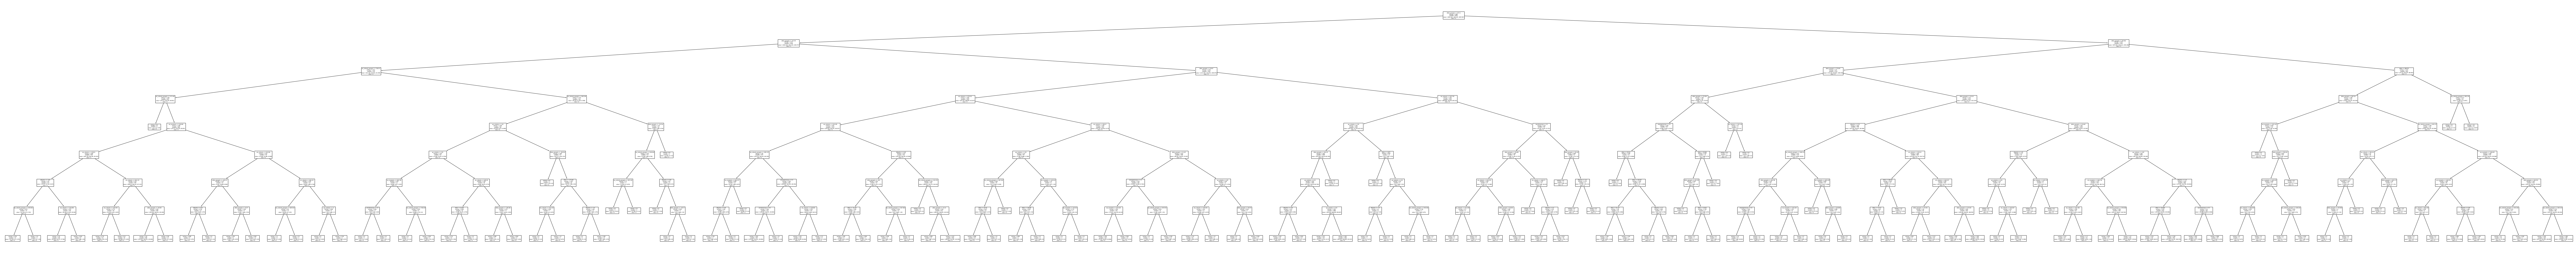

In [122]:
plt.figure(figsize = (200,20))
plot_tree(decision_tree = clf_arvore_decisao.best_estimator_['arvore_decisao'], feature_names = df_partidas_20092017[lst_covariaveis].columns,  class_names = ['A', 'D', 'H'])

A importância das covariáveis está exibida abaixo. Veja que a covariável "difelo_pesogols" que é a medida de desempenho anterior das equipes ponderada pelos gols marcados e sofridos foi de longe a mais importante para construção da árvore.

In [128]:
pd.DataFrame({'covariaveis': lst_covariaveis, 'importancia': clf_arvore_decisao.best_estimator_['arvore_decisao'].feature_importances_}).sort_values('importancia', ascending = False)


,covariaveis,importancia
1,difelo_pesogols,0.356251
2,elo_visitante,0.168892
4,elo_visitante_pesogols,0.127158
8,difpontos,0.086115
0,difelo,0.077566
7,apr_visitante,0.071794
6,elo_mandante,0.069294
5,semvitmancasa,0.021539
3,empsegmancasa,0.021390


### Classificador Árvore de Decisão com melhor trade-off entre acurácia e f1_score

Como vimos na estimação da Árvore anterior, os hiperparâmetros que levaram a maior soma entre acurácia média em teste e f1_score médio nos folds de teste foi aquela sem peso nas classes e com profundidade máxima igual a 10. A acurácia média dessa árvore nos folds de teste foi igual a 46,79% e o f1_score médio nos folds de teste foi de 34,24%. Vamos estimar essa árvore aqui e verificar se ela consegue fazer estimativas diferentes da classe dominante e como essas estimativas estão em treino.

In [124]:
# Criando o classificador
clf_arvore_decisao1 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10)

# ajustando o algoritmo aos dados do nosso estudo
clf_arvore_decisao1.fit(X = df_partidas_20092017[lst_covariaveis],
                        y = df_partidas_20092017['resultado_final'])

DecisionTreeClassifier(criterion='entropy', max_depth=10)

Abaixo estão expostas as estatísticas de resumo da árvore de decisão que levou a melhor soma média das métricas de acurácia e f1_score nos folds de treino. Verifique que a classe dominante H possui maiores probabilidades mas que esses valores variam entre observações. A diferença interquartílica para da classe H por exemplo, é de [0,4; 0,557].

In [125]:
pd.DataFrame(clf_arvore_decisao1.predict_proba(df_partidas_20092017[lst_covariaveis]), columns = ['A', 'D', 'H']).describe().round(3)

,A,D,H
count,8093.000,8093.000,8093.000
mean,0.238,0.268,0.494
std,0.158,0.154,0.190
min,0.000,0.000,0.000
25%,0.176,0.243,0.400
50%,0.199,0.261,0.496
75%,0.308,0.291,0.557
max,1.000,1.000,1.000


Abaixo estão as tabelas de frequência das estimativas do classificador árvore de decisão com profundidade máxima igual a 10 e sem peso nos erros das classes. Note que esse classificador estima 76,98% das observações em treino como sendo **vitória do mandante** (H), esse é um valor alto mas não é tão exagerado como o que vimos para a regressão logística sem peso das classes por exemplo. Na matriz de confusão podemos ver que o classificador teve um bom desempenho em prever classes diferentes da H, porém temos que lembrar que os resultados que ele obteve de acurácia em treino são relativamente maiores que a acurácia em teste.

In [126]:
df_tabela = pd.DataFrame(pd.DataFrame(clf_arvore_decisao1.predict(df_partidas_20092017[lst_covariaveis])).value_counts(), 
                         columns = ['classe'])
df_tabela['prop'] = round(df_tabela['classe']/sum(df_tabela['classe']), ndigits = 4)
df_tabela

,classe,prop
0,,
H,6230,0.7698
A,1190,0.1470
D,673,0.0832


In [127]:
pd.DataFrame(confusion_matrix(y_true = df_partidas_20092017['resultado_final'], 
                              y_pred = clf_arvore_decisao1.predict(df_partidas_20092017[lst_covariaveis]), labels = ['A', 'D', 'H']), 
             columns = ['pred_A', 'pred_D', 'pred_H'], index = ['real_A', 'real_D', 'real_H'])


,pred_A,pred_D,pred_H
real_A,590,100,1238
real_D,241,432,1495
real_H,359,141,3497


Na importância das covariáveis para construção dessa árvore, note que a variável diferença de elo das equipes ponderada pelos gols foi muito superior em importância em relação as demais.

In [129]:
pd.DataFrame({'covariaveis': lst_covariaveis, 'importancia': clf_arvore_decisao1.feature_importances_}).sort_values('importancia', ascending = False)


,covariaveis,importancia
1,difelo_pesogols,0.256707
6,elo_mandante,0.157058
0,difelo,0.133558
4,elo_visitante_pesogols,0.126653
2,elo_visitante,0.105185
7,apr_visitante,0.094395
8,difpontos,0.086756
5,semvitmancasa,0.020308
3,empsegmancasa,0.019379


## **Classificador KNN**

O próximo classificador a ser ajustado é o KNN. Esse é um classificador simples que se baseia em distâncias para fazer suas previsões a partir dos k vizinhos mais próximos. O único hiperparâmetro desse algoritmo é o número de vizinhos a ser considerado. Os dados estão sendo padronizados antes da execução do algoritmo e note que não está sendo considerado peso para as classes aqui.

In [36]:
# APROXIMADAMENTE 1 MINUTO E 30 PARA EXECUTAR
pipeline_knn = Pipeline(
    steps = [('padronizacao covariaveis', StandardScaler()),
             ('knn', KNeighborsClassifier())])

# definindo os valores possíveis para o hiperparâmetro kernel.
hiperparametros_knn = {'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 
                                            70, 80, 90, 100, 200, 300, 400, 500, 1000]}

clf_knn = GridSearchCV(estimator = pipeline_knn, param_grid = hiperparametros_knn,
                       cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 25031908),
                       n_jobs = -1, scoring = ['accuracy', 'f1_macro'], refit = 'f1_macro', 
                       return_train_score = True, verbose = True)


# ajustando o algoritmo aos dados do nosso estudo
clf_knn.fit(X = df_partidas_20092017[lst_covariaveis], y = df_partidas_20092017['resultado_final'])

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   26.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25031908, shuffle=True),
             estimator=Pipeline(steps=[('padronizacao covariaveis',
                                        StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20,
                                              30, 40, 50, 60, 70, 80, 90, 100,
                                              200, 300, 400, 500, 1000]},
             refit='f1_macro', return_train_score=True,
             scoring=['accuracy', 'f1_macro'], verbose=True)

Abaixo estão expostos os resultados da busca por grid do hiperparâmetro que maximiza o f1_score no conjunto de teste nos folds de validação. Veja que o hiperparâmetro número de vizinhos que apresentou melhor resultado para essa métrica nos folds de teste foi com k igual a 8, com acurácia média em teste igual a 42,90% e f1_score de 36,60%. No entanto, o classificador KNN que melhor apresentou soma entre acurácia e f1_score médios em teste foi o com 20 vizinhos. Com acurácia média em teste de 46,58% e f1_score médio em teste de 34,60%.

In [131]:
formata_cv_resultados(clf_knn.cv_results_).drop('params', axis = 1)

,mean_fit_time,param_knn__n_neighbors,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,mean_train_f1_macro,std_train_f1_macro,soma
10,0.059045,20,0.465833,0.010006,14,0.527246,0.000929,0.346044,0.012498,9,0.425033,0.002751,0.811877
12,0.058555,40,0.485111,0.006201,11,0.512325,0.001833,0.325693,0.008918,13,0.363358,0.006261,0.810803
11,0.059202,30,0.472754,0.002831,13,0.514982,0.001007,0.327126,0.004658,12,0.382960,0.002966,0.799880
13,0.058971,50,0.484246,0.003166,12,0.509700,0.001165,0.311344,0.008684,14,0.347670,0.006786,0.795590
7,0.057044,8,0.429013,0.011349,17,0.570277,0.003815,0.366075,0.013916,1,0.523444,0.004703,0.795088
8,0.062178,9,0.433708,0.008768,16,0.562616,0.005412,0.356981,0.009247,6,0.504753,0.006773,0.790689
9,0.060574,10,0.436426,0.010455,15,0.556283,0.005578,0.354186,0.008527,7,0.494472,0.007045,0.790611
6,0.059397,7,0.424810,0.010434,18,0.582169,0.006154,0.364499,0.008844,2,0.538160,0.005715,0.789310
14,0.060453,60,0.486222,0.003096,10,0.507537,0.001932,0.302387,0.003916,15,0.333147,0.007343,0.788609
17,0.063455,90,0.495366,0.003834,5,0.502348,0.002389,0.292310,0.003356,18,0.303619,0.007241,0.787675


As estatísticas de resumo das probabilidades previstas pelo KNN com 8 vizinhos no conjunto de treino estão exibidas abaixo. Veja que ao contrário da árvore de decisão e da regressão logística que levaram em consideração um peso para balancear as classes, o classificador knn teve média da probabilidade para cada uma das classes parecidas com as proporções de cada resultado. O problema é que cada classe só pode assumir 8 valores distintos para as probabilidade das classes em cada partida.

In [38]:
pd.DataFrame(clf_knn.predict_proba(df_partidas_20092017[lst_covariaveis]), columns = ['A', 'D', 'H']).describe().round(3)

,A,D,H
count,8093.000,8093.000,8093.000
mean,0.238,0.266,0.496
std,0.165,0.160,0.196
min,0.000,0.000,0.000
25%,0.125,0.125,0.375
50%,0.250,0.250,0.500
75%,0.375,0.375,0.625
max,1.000,0.875,1.000


Abaixo há uma tabela de frequência das previsões das classes feitas pelo classificador knn com 8 vizinhos e também a matriz de confusão. Note que o classificador previu 56,75% das partidas como vitória do mandante (H), esse é um percentual maior do que a Regressão Logística e a Árvore de Decisão considerando peso nas classes, mas não é uma proporção tão grande como > 90% que eu disse no começo que existia quando só a acurácia é considerada como medida de qualidade do classificador e como vimos na Regressão Logística sem peso nas classses. Na matriz de confusão obtivemos resultados legais, não bons, mas melhores que nos outros classificadores. A taxa de acerto do classificador quando previu resultado como vitória do visitante foi (A) de 46,69% (861/total de predições na classe A) e quando previu empate foi de 50,36% (834/total de predições na calsse D), resultados superiores aos classificadores anteriores.

In [39]:
df_tabela = pd.DataFrame(pd.DataFrame(clf_knn.predict(df_partidas_20092017[lst_covariaveis])).value_counts(), 
                         columns = ['classe'])
df_tabela['prop'] = round(df_tabela['classe']/sum(df_tabela['classe']), ndigits = 4)
df_tabela

,classe,prop
0,,
H,4593,0.5675
A,1844,0.2279
D,1656,0.2046


In [40]:
pd.DataFrame(confusion_matrix(y_true = df_partidas_20092017['resultado_final'], 
                              y_pred = clf_knn.predict(df_partidas_20092017[lst_covariaveis]), labels = ['A', 'D', 'H']), 
             columns = ['pred_A', 'pred_D', 'pred_H'], index = ['real_A', 'real_D', 'real_H'])


,pred_A,pred_D,pred_H
real_A,861,292,775
real_D,437,834,897
real_H,546,530,2921


### **Classificador KNN com melhor trade-off entre acurácia e f1_score**

Como vimos anteriormente, o classificador knn que apresentou melhor resultado da soma da acurácia média em teste e do f1_score médio em teste foi o com 20 vizinhos. Esse classificador apresentou valores de 46,58% e 34,60%, respectivamente. Isso significa que o ganho de acurácia de aumentar de 8 para 20 vizinhos foi significativo e não abaixou tanto o f1_score esperado. Vamos treinar esse classificador e olhar para suas métricas em treino para avaliar seus resultados.

In [133]:
# fluxo de tarefas a serem executadas com as covariáveis
clf_knn1 = Pipeline(
    steps = [('padronizacao covariaveis', StandardScaler()),
             ('knn', KNeighborsClassifier(n_neighbors = 20))])

# ajuste de fato do algoritmo
clf_knn1.fit(X = df_partidas_20092017[lst_covariaveis], y = df_partidas_20092017['resultado_final'])

Pipeline(steps=[('padronizacao covariaveis', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=20))])

As estatísticas de resumo das probabilidades previstas pelo KNN com 20 vizinhos no conjunto de treino estão exibidas abaixo. Note que os valores das probabilidades variam de observação para observação e que esse classificador consegue estimar probabilidades grandes para as classes A e D. O intervalo interquartílico para a classe dominante é [0,4; 0,6].

In [134]:
pd.DataFrame(clf_knn1.predict_proba(df_partidas_20092017[lst_covariaveis]), columns = ['A', 'D', 'H']).describe().round(3)

,A,D,H
count,8093.000,8093.000,8093.000
mean,0.240,0.264,0.496
std,0.117,0.102,0.138
min,0.000,0.000,0.100
25%,0.150,0.200,0.400
50%,0.250,0.250,0.500
75%,0.300,0.350,0.600
max,0.700,0.700,1.000


Abaixo estão as tabelas de frequência das estimativas desse classificador em dados de treino. Veja que ele prevê muitas observações como **vitória do mandante** mas não tantas como outros classificadores. Na matriz de confusão, note como esse classificador conseguiu prever quantidades significativas fora da classe dominante. A taxa de acerto do classificador quando previu resultado como vitória do visitante foi (A) de 44% (502/total de predições na classe A) e quando previu empate foi de 44,25% (435/total de predições na calsse D), resultados superiores aos classificadores anteriores.

In [135]:
df_tabela = pd.DataFrame(pd.DataFrame(clf_knn1.predict(df_partidas_20092017[lst_covariaveis])).value_counts(), 
                         columns = ['classe'])
df_tabela['prop'] = round(df_tabela['classe']/sum(df_tabela['classe']), ndigits = 4)
df_tabela

,classe,prop
0,,
H,5969,0.7376
A,1141,0.1410
D,983,0.1215


In [136]:
pd.DataFrame(confusion_matrix(y_true = df_partidas_20092017['resultado_final'], 
                              y_pred = clf_knn1.predict(df_partidas_20092017[lst_covariaveis]), labels = ['A', 'D', 'H']), 
             columns = ['pred_A', 'pred_D', 'pred_H'], index = ['real_A', 'real_D', 'real_H'])


,pred_A,pred_D,pred_H
real_A,502,214,1212
real_D,290,435,1443
real_H,349,334,3314


### **Classificador SVM**

O próximo algoritmo a ser treinado é o SVM. O primeiro passo do fluxo de tarefas a ser executada aos dados é padronizar as covariaveis, deixá-las com média 0 e variância 1. Daí será feita a busca por hiperparâmetros. Aqui vou variar o kernel do SVM e o valor de C que pune as observações que caem dentro da margem e consequentemente aumenta o seu tamanho. Não usarei o hiperparâmetro para punir mais erros em uma classe que outras porque o custo computacional é muito grande.


In [52]:
# 33 MINUTOS PARA EXECUTAR
# fluxo de tarefas que serão executadas as observações do conjunto de treinamento
pipeline_svm = Pipeline(steps = [('padronizacao covariaveis', StandardScaler()),
                                 ('svm', SVC(probability = True))])

# definindo as combinações de valores possíveis para o hiperparâmetro kernel e o 
# hiperparâmetro C.
hiperparametros_svm = {'svm__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
                       'svm__C': [0.1, 1, 10]}

# Arquitetando a busca pela melhor configuração dos hiperparametros nos nossos dados 
# através de validação cruzada.
clf_svm = GridSearchCV(estimator = pipeline_svm, param_grid = hiperparametros_svm, 
                       cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 25031908), 
                       n_jobs = -1, scoring = ['accuracy', 'f1_macro'], refit = 'f1_macro', 
                       return_train_score = True, verbose = True)

# ajustando o algoritmo aos dados do nosso estudo
clf_svm.fit(X = df_partidas_20092017[lst_covariaveis], y = df_partidas_20092017['resultado_final'])


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 13.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25031908, shuffle=True),
             estimator=Pipeline(steps=[('padronizacao covariaveis',
                                        StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10],
                         'svm__kernel': ['linear', 'rbf', 'sigmoid', 'poly']},
             refit='f1_macro', return_train_score=True,
             scoring=['accuracy', 'f1_macro'], verbose=True)

A combinação de hiperparâmetros que levou a melhor acurácia média nos folds de teste do SVM foi com C igual a 1 e kernel igual a rbf, só que esse classificador teve média do f1_score nos folds de teste de apenas 25,94%. A coombinação de hiperparâmetros que levou a melhor média de f1_score nos folds de teste foi com kernel sigmoid e C igual a 0,1, um classificador bem rígido com observações mal-classificadas e também com margem pequena. A acurácia média em teste do SVM com os hiperparâmetros que levaram ao melhor f1_score médio foi de 41,20%. Já o classificador que teve melhor trade-off entre essas duas métricas foi o com kernel rbf e C igual a 10, ele será ajustado assim que mostrado os resultados para o SVM de melhor f1-score médio em teste.

In [139]:
formata_cv_resultados(clf_svm.cv_results_).drop('params', axis = 1)

,mean_fit_time,param_svm__C,param_svm__kernel,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,mean_train_f1_macro,std_train_f1_macro,soma
9,44.166328,10,rbf,0.492649,0.005508,9,0.537440,0.001627,0.295790,0.010222,4,0.365661,0.004268,0.788439
5,36.316824,1,rbf,0.495120,0.003855,1,0.506487,0.002359,0.259454,0.006130,5,0.277950,0.008811,0.754573
2,24.800450,0.1,sigmoid,0.412082,0.017419,10,0.404238,0.012640,0.331469,0.017108,1,0.324694,0.015534,0.743551
11,438.958959,10,poly,0.494007,0.001081,3,0.495614,0.000597,0.224113,0.003528,6,0.227480,0.003132,0.718120
7,128.017748,1,poly,0.493884,0.000984,4,0.495335,0.000416,0.223446,0.002975,7,0.226130,0.002289,0.717330
1,21.603854,0.1,rbf,0.494007,0.000796,2,0.494316,0.000764,0.221440,0.002209,8,0.222480,0.003923,0.715448
3,51.080386,0.1,poly,0.493884,0.000533,8,0.494501,0.000377,0.221430,0.000771,9,0.222587,0.001001,0.715313
6,22.375350,1,sigmoid,0.398618,0.022745,11,0.398646,0.021950,0.316602,0.016558,2,0.315878,0.017942,0.715220
0,8.919515,0.1,linear,0.493884,0.000232,4,0.493884,0.000058,0.220403,0.000069,10,0.220403,0.000017,0.714286
4,21.525634,1,linear,0.493884,0.000232,4,0.493884,0.000058,0.220403,0.000069,10,0.220403,0.000017,0.714286


As estatísticas de resumo do classificador SVM com C igual a 0,1 e kernel igual a sigmoid estão exibidas abaixo. Note que a maioria das probabilidades das observações ficaram muito parecidas, ou seja, apesar das diferenças entre as covariáveis, as probabilidades de cada classe ficaram quase que iguais. A diferença interquatílica para a classe 'H' por exemplo foi muito pequena, com os valores iguais a [0,491; 0,498], sinal claro de *underfitting*, pois o classificador sempre estima as classes com probabilidades muito parecidas, independente dos valores assumidos pelas covariáveis.

In [140]:
pd.DataFrame(clf_svm.predict_proba(df_partidas_20092017[lst_covariaveis]), columns = ['A', 'D', 'H']).describe().round(3)

,A,D,H
count,8093.000,8093.000,8093.000
mean,0.239,0.266,0.495
std,0.001,0.014,0.014
min,0.236,0.176,0.352
25%,0.238,0.258,0.488
50%,0.239,0.266,0.496
75%,0.239,0.274,0.503
max,0.251,0.407,0.574


Abaixo está exibida a tabela das frequências das estimativas das classes e a matriz de confusão gerada a partir das previsões feitas pelo classificador, veja que o classificador estimou que cerca de 65% das observações na classe 'H'. Além disso foi predito pouquíssimas observações na classe 'A' (**vitória do visitante**). Na matriz de confusão vemos que o problema é ainda pior, mesmo o classificador prevendo poucas observações nas classes A e D, quando o faz ainda possui uma taxa de acerto muito baixa. Das previsões que o SVM fez na classe A (**vitória do visitante**), somente 25,65% (98/total de predições na classe A) se confirmaram. Das previsões que o SVM fez na classe D (**empate**), somente 26,78% delas se confirmaram (693/total de predições na classe D).

In [141]:
df_tabela = pd.DataFrame(pd.DataFrame(clf_svm.predict(df_partidas_20092017[lst_covariaveis])).value_counts(), 
                         columns = ['classe'])
df_tabela['prop'] = round(df_tabela['classe']/sum(df_tabela['classe']), ndigits = 4)
df_tabela

,classe,prop
0,,
H,5124,0.6331
D,2587,0.3197
A,382,0.0472


In [142]:
pd.DataFrame(confusion_matrix(y_true = df_partidas_20092017['resultado_final'], 
                              y_pred = clf_svm.predict(df_partidas_20092017[lst_covariaveis]), labels = ['A', 'D', 'H']), 
             columns = ['pred_A', 'pred_D', 'pred_H'], index = ['real_A', 'real_D', 'real_H'])

,pred_A,pred_D,pred_H
real_A,98,650,1180
real_D,109,693,1366
real_H,175,1244,2578


### **Classificador SVM com melhor trade-off entre acurácia e f1_score**

Como vimos anteriormente os hiperparâmetros que levaram ao SVM com maior soma entre acurácia média em teste e f1_score médio em teste foi aquele com kernel igual a rbf e C igual a 10. Esse classificador levou a uma acurácia média em teste de 49,26% e f1_score médio em treino de 29,57%, um valor de acurácia alto e de f1_score médio menor do que já vimos em outros classificadores. Provavelmente esse classificador prevê muitas observações como **vitória do mandante** (classe H). Vamos ajustá-lo.


In [143]:
# fluxo de tarefas que serão executadas as observações do conjunto de treinamento
clf_svm1 = Pipeline(steps = [('padronizacao covariaveis', StandardScaler()),
                             ('svm', SVC(probability = True, kernel = 'rbf', C = 10))])

# ajustando o algoritmo aos dados do nosso estudo
clf_svm1.fit(X = df_partidas_20092017[lst_covariaveis], y = df_partidas_20092017['resultado_final'])

Pipeline(steps=[('padronizacao covariaveis', StandardScaler()),
                ('svm', SVC(C=10, probability=True))])

As estatísticas de resumo do classificador SVM com C igual a 10 e kernel igual a rbf estão exibidas abaixo. Note que diferente do SVM anterior, esse consegue variar mais as probabilidades das observações, mas ainda assim a variação é muito pouca. O intervalo interquartílico para a classe H é [0,496; 0,516], diferença quase nula de probabilidade para 50% das observações em treino.

In [144]:
pd.DataFrame(clf_svm1.predict_proba(df_partidas_20092017[lst_covariaveis]), columns = ['A', 'D', 'H']).describe().round(3)

,A,D,H
count,8093.000,8093.000,8093.000
mean,0.237,0.268,0.495
std,0.036,0.022,0.045
min,0.138,0.176,0.214
25%,0.218,0.259,0.496
50%,0.224,0.265,0.513
75%,0.238,0.271,0.516
max,0.510,0.461,0.631


As tabelas abaixo exibem a frequência das previsões em cada classe das observações do treino feitas por esse classificador. Realmente ele prevê muitas observações como sendo da classe 'H' e que apesar de estimar poucas observações nas classes A e D, quando o faz, obtém resultados bons, mesmo não tendo uma acurácia em teste tão alta (53,74%). Das previsões que o SVM fez na classe A (vitória do visitante), 59,25% (285/total de predições na classe A) se confirmaram. Das previsões que o SVM fez na classe D (empate), 66,27% delas se confirmaram (169/total de predições na classe D).

In [145]:
df_tabela = pd.DataFrame(pd.DataFrame(clf_svm1.predict(df_partidas_20092017[lst_covariaveis])).value_counts(), 
                         columns = ['classe'])
df_tabela['prop'] = round(df_tabela['classe']/sum(df_tabela['classe']), ndigits = 4)
df_tabela

,classe,prop
0,,
H,7357,0.9091
A,481,0.0594
D,255,0.0315


In [146]:
pd.DataFrame(confusion_matrix(y_true = df_partidas_20092017['resultado_final'], 
                              y_pred = clf_svm1.predict(df_partidas_20092017[lst_covariaveis]), labels = ['A', 'D', 'H']), 
             columns = ['pred_A', 'pred_D', 'pred_H'], index = ['real_A', 'real_D', 'real_H'])

,pred_A,pred_D,pred_H
real_A,285,39,1604
real_D,91,169,1908
real_H,105,47,3845


## **Classificador Random Forest**

Entrando nos classificadores *ensemble*, o primeiro a ser treinado vai ser as *Random Forests*. Os hiperparâmetros testados aqui serão o número de árvores na floresta, a profundidade máxima de cada árvore e o peso ou não das classes.

In [41]:
# APROXIMADAMENTE 15 MINUTOS PARA EXECUTAR
# criação do classificador a partir do algoritmo random forest.
pipeline_floresta_aleatoria = RandomForestClassifier(criterion = 'entropy')

# definindo os valores possíveis para os hiperparâmetros.
hiperparametro_floresta_aleatoria = {'n_estimators': [1, 2, 5, 10, 20, 50, 100, 200], 
                                     'max_depth': [1, 2, 3, 4, 5, 10, 20, 50, None],
                                    'class_weight': [None, 'balanced', {'H' : 1, 'D': 10, 'A': 10}]}

# criando o grid que irá testar todos esses números de árvores da floresta e retornar
# o melhor a partir da avaliação dos resultados através de validação cruzada.
clf_floresta_aleatoria = GridSearchCV(estimator = pipeline_floresta_aleatoria, 
                                       param_grid = hiperparametro_floresta_aleatoria, 
                                       cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 25031908), 
                                       n_jobs = -1, scoring = ['accuracy', 'f1_macro'], refit = 'f1_macro', 
                                       return_train_score = True, verbose = True)

# ajustando o algoritmo da floresta aleatória aos dados do nosso estudo
clf_floresta_aleatoria.fit(X = df_partidas_20092017[lst_covariaveis], y = df_partidas_20092017['resultado_final'])

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 832 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  4.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25031908, shuffle=True),
             estimator=RandomForestClassifier(criterion='entropy'), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced',
                                          {'A': 10, 'D': 10, 'H': 1}],
                         'max_depth': [1, 2, 3, 4, 5, 10, 20, 50, None],
                         'n_estimators': [1, 2, 5, 10, 20, 50, 100, 200]},
             refit='f1_macro', return_train_score=True,
             scoring=['accuracy', 'f1_macro'], verbose=True)

Abaixo estão os resultados do treino. Podemos notar que a árvore que levou a melhor resultado de f1_score médio em treino foi aquela com 50 árvores com cada uma delas tendo profundidade igual a 10 com valor de 39,50%. A acurácia média nos folds de teste dessa floresta também não foi desprezível, 43,86%. Essa também foi a floresta com maior soma entre essas duas métricas em teste.

In [147]:
formata_cv_resultados(clf_floresta_aleatoria.cv_results_).drop('params', axis = 1)

,mean_fit_time,param_class_weight,param_max_depth,param_n_estimators,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,mean_train_f1_macro,std_train_f1_macro,soma
117,1.886473,balanced,10,50,0.438652,0.008397,80,0.748856,0.012251,0.395069,0.006965,1,0.739538,0.012521,0.833720
102,1.838102,balanced,4,100,0.431858,0.014247,87,0.465556,0.004528,0.392804,0.012171,2,0.433176,0.004309,0.824662
119,8.497792,balanced,10,200,0.436058,0.009423,83,0.768998,0.007418,0.388584,0.012129,4,0.761451,0.007200,0.824641
126,7.656858,balanced,20,100,0.465093,0.010310,60,0.999938,0.000124,0.357567,0.010554,57,0.999938,0.000123,0.822659
118,4.242695,balanced,10,100,0.434203,0.011035,86,0.764735,0.006228,0.387289,0.008767,7,0.756536,0.006384,0.821492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1.604957,"{'H': 1, 'D': 10, 'A': 10}",1,200,0.272582,0.004793,205,0.281571,0.003344,0.211574,0.019608,214,0.223735,0.021434,0.484156
176,0.054627,"{'H': 1, 'D': 10, 'A': 10}",5,1,0.260349,0.004219,216,0.288397,0.008986,0.223468,0.014088,195,0.252788,0.013164,0.483817
144,0.036123,"{'H': 1, 'D': 10, 'A': 10}",1,1,0.268012,0.014696,213,0.266156,0.003528,0.214602,0.040444,213,0.213908,0.036889,0.482615
146,0.074235,"{'H': 1, 'D': 10, 'A': 10}",1,5,0.270604,0.003138,210,0.274682,0.005571,0.199816,0.048306,216,0.204156,0.051701,0.470421


Abaixo estão as estatísticas de resumo das probabilidades das predições em treino das classes pela random forest com melhor desempenho nos folds de teste. Note que as probabilidades possuem alguma variabilidade, o que é interessante. O intervalo interquartílico para a classe H, por exemplo, foi de [0,28; 0,396];

In [149]:
pd.DataFrame(clf_floresta_aleatoria.predict_proba(df_partidas_20092017[lst_covariaveis]), columns = ['A', 'D', 'H']).describe().round(3)

,A,D,H
count,8093.000,8093.000,8093.000
mean,0.313,0.323,0.364
std,0.105,0.078,0.115
min,0.001,0.001,0.057
25%,0.245,0.278,0.282
50%,0.302,0.317,0.352
75%,0.376,0.360,0.429
max,0.760,0.813,0.997


Abaixo estão a tabela de frequência das previsões da classe estimada para as partidas através do classificador e a matriz de confusão gerada a partir das previsões do mesmo classificador. Veja que 47,05% das estimativas do classificador foram para a classe 'H' (**vitória do mandante**), um valor que é bom mas seria mais interessante se a acurácia média em treino fosse menor que os 74,88% que obteve. Esse classificador conseguiu uma acurácia que não é desprezível sem prever todas as observações na classe 'H'. Na matriz de confusão podemos ver que o classificador conseguiu ir razoavelmente bem nas classes menos dominantes. Quando a floresta aleatória com peso entre as classes balanceadas com 50 árvores de profundidade 10 cada estimou que as observações seriam **vitória do visitante** (A) acertou em 60,25% das vezes (1439/total de predições na classe A) e quando estimou que as partidas terminariam empatadas, o classificador acertou em 76,33% das vezes (1448/total de predições na classe D). O maior problema foi que a acurácia média em treino foi alta, mas parece ser um bom candidato a classificador final.	

In [151]:
df_tabela = pd.DataFrame(pd.DataFrame(clf_floresta_aleatoria.predict(df_partidas_20092017[lst_covariaveis])).value_counts(), 
                         columns = ['classe'])
df_tabela['prop'] = round(df_tabela['classe']/sum(df_tabela['classe']), ndigits = 4)
df_tabela

,classe,prop
0,,
H,3808,0.4705
A,2388,0.2951
D,1897,0.2344


In [152]:
pd.DataFrame(confusion_matrix(y_true = df_partidas_20092017['resultado_final'], 
                              y_pred = clf_floresta_aleatoria.predict(df_partidas_20092017[lst_covariaveis]), labels = ['A', 'D', 'H']), 
             columns = ['pred_A', 'pred_D', 'pred_H'], index = ['real_A', 'real_D', 'real_H'])

,pred_A,pred_D,pred_H
real_A,1439,82,407
real_D,271,1448,449
real_H,678,367,2952


Abaixo os percentuais de importância das covariáveis para o treinamento da floresta aleatória. Veja que as variáveis que medem a diferença entre o histórico de desempenho das equipes ponderado ou não pelos gols foram as mais importantes.

In [153]:
pd.DataFrame({'covariaveis': lst_covariaveis, 'importancia': 100*clf_floresta_aleatoria.best_estimator_.feature_importances_}).sort_values('importancia', ascending = False)

,covariaveis,importancia
1,difelo_pesogols,17.849016
0,difelo,17.204636
4,elo_visitante_pesogols,13.862527
2,elo_visitante,13.472236
6,elo_mandante,13.465501
8,difpontos,9.403439
7,apr_visitante,8.742654
5,semvitmancasa,3.644134
3,empsegmancasa,2.355857


## **Classificador Random Forest sem peso nas classes**

Agora vamos verificar o desempenho do classificador do tipo floresta aleatória sem peso nas classes e que obteve o melhor resultado de f1_score médio nos folds de teste dentre aqueles que não tinham peso nas classes. Veja que é o classificador com 100 árvores na floresta e com cada árvore com profundidade máxima igual a 20. Apesar desse classificador ter *overfitting* nos folds de treino (acurácia média de 99,69%) em treino, ele obteve valor de 47,55% de acurácia média em teste sem os sinais de prever todas as observações na classe 'H'. Vamos ajustá-lo para ver mais detalhes desse classificador.

In [163]:
formata_cv_resultados(clf_floresta_aleatoria.cv_results_)[pd.isnull(pd.DataFrame(formata_cv_resultados(clf_floresta_aleatoria.cv_results_))['param_class_weight'])]

,mean_fit_time,param_class_weight,param_max_depth,param_n_estimators,params,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,mean_train_f1_macro,std_train_f1_macro,soma
54,5.313492,None,20,100,"{'class_weight': None, 'max_depth': 20, 'n_est...",0.475596,0.005573,47,0.996942,0.001400,0.339436,0.010129,102,0.996935,0.001391,0.815032
71,13.411108,None,None,200,"{'class_weight': None, 'max_depth': None, 'n_e...",0.468181,0.006508,56,1.000000,0.000000,0.346140,0.005567,89,1.000000,0.000000,0.814321
42,0.226016,None,10,5,"{'class_weight': None, 'max_depth': 10, 'n_est...",0.473622,0.010487,51,0.620784,0.009147,0.340632,0.009953,100,0.537126,0.017598,0.814254
55,10.946446,None,20,200,"{'class_weight': None, 'max_depth': 20, 'n_est...",0.476955,0.005693,46,0.997590,0.000980,0.335692,0.010145,108,0.997565,0.000982,0.812647
60,1.145803,None,50,20,"{'class_weight': None, 'max_depth': 50, 'n_est...",0.446556,0.012226,75,0.998208,0.000540,0.365783,0.011408,43,0.998181,0.000543,0.812339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,1.125224,None,1,200,"{'class_weight': None, 'max_depth': 1, 'n_esti...",0.493884,0.000232,25,0.493884,0.000058,0.220403,0.000069,197,0.220403,0.000017,0.714286
14,0.765190,None,2,100,"{'class_weight': None, 'max_depth': 2, 'n_esti...",0.493760,0.000361,35,0.493976,0.000202,0.220366,0.000108,206,0.220928,0.000703,0.714126
49,0.119198,None,20,2,"{'class_weight': None, 'max_depth': 20, 'n_est...",0.363771,0.012088,159,0.753892,0.006854,0.349754,0.011154,77,0.746101,0.008325,0.713524
65,0.166855,None,None,2,"{'class_weight': None, 'max_depth': None, 'n_e...",0.331030,0.011288,165,0.768133,0.003534,0.328842,0.011224,118,0.764832,0.003476,0.659872


In [159]:
# definindo parametros do classificador
clf_floresta_aleatoria1 = RandomForestClassifier(criterion = 'entropy', max_depth = 20, n_estimators = 100)

# ajustando o algoritmo aos dados do nosso estudo
clf_floresta_aleatoria1.fit(X = df_partidas_20092017[lst_covariaveis], y = df_partidas_20092017['resultado_final'])

RandomForestClassifier(criterion='entropy', max_depth=20)

As estatísticas de resumo das probabilidades estimadas pelo classificador nos dados de treino estão exibidas abaixo, note que as probabilides em cada classe possuem uma boa variação. O intervalo interquartílico para as observações na classe H foi de [0,247. 0,737].

In [160]:
pd.DataFrame(clf_floresta_aleatoria1.predict_proba(df_partidas_20092017[lst_covariaveis]), columns = ['A', 'D', 'H']).describe().round(3)

,A,D,H
count,8093.000,8093.000,8093.000
mean,0.239,0.268,0.493
std,0.218,0.220,0.257
min,0.000,0.000,0.016
25%,0.095,0.119,0.247
50%,0.140,0.162,0.435
75%,0.256,0.493,0.737
max,0.881,0.871,1.000


Como esse classificador entrou em *overfitting* com os dados de treino, obviamente ele acerta quase tudo nas estimativas. Os resultados dele em treino não serviram para investigar o que buscávamos por conta do *overfitting*, mas já que ele foi ajustado, vamos levá-lo a avaliação final dos classificadores.

In [161]:
df_tabela = pd.DataFrame(pd.DataFrame(clf_floresta_aleatoria1.predict(df_partidas_20092017[lst_covariaveis])).value_counts(), 
                         columns = ['classe'])
df_tabela['prop'] = round(df_tabela['classe']/sum(df_tabela['classe']), ndigits = 4)
df_tabela

,classe,prop
0,,
H,4031,0.4981
D,2153,0.2660
A,1909,0.2359


In [162]:
pd.DataFrame(confusion_matrix(y_true = df_partidas_20092017['resultado_final'], 
                              y_pred = clf_floresta_aleatoria1.predict(df_partidas_20092017[lst_covariaveis]), labels = ['A', 'D', 'H']), 
             columns = ['pred_A', 'pred_D', 'pred_H'], index = ['real_A', 'real_D', 'real_H'])

,pred_A,pred_D,pred_H
real_A,1909,0,19
real_D,0,2153,15
real_H,0,0,3997


Abaixo estão as importâncias das covariáveis no ajuste dessa floresta. Note que as variáveis de elo ficaram quase que empatadas como as mais importantes.

In [164]:
pd.DataFrame({'covariaveis': lst_covariaveis, 'importancia': 100*clf_floresta_aleatoria1.feature_importances_}).sort_values('importancia', ascending = False)

,covariaveis,importancia
1,difelo_pesogols,15.823073
0,difelo,14.941070
4,elo_visitante_pesogols,14.791736
6,elo_mandante,14.193362
2,elo_visitante,14.133364
8,difpontos,9.980849
7,apr_visitante,9.562445
5,semvitmancasa,4.190528
3,empsegmancasa,2.383574


## **Classificador Adaboost**

O próximo classificador *ensemble* será o Adaboost. Esse classificador foi estudado durante as nossas aulas e também no trabalho prático 2. O hiperparâmetro que vai ser testado aqui por meio de validação cruzada é o número de iterações do algoritmo. Os dados não serão padronizados antes, porque não faz grande diferença para o Adaboost. Aqui não é considerado peso das classes.

In [165]:
# APROXIMADAMENTE 2 MINUTOS E 15 PARA EXECUTAR
pipeline_adaboost = AdaBoostClassifier(algorithm = 'SAMME')

# definindo os valores possíveis para o hiperparâmetro número de árvores na floresta.
hiperparametro_adaboost = {'n_estimators': [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]}

# criando o grid que irá testar todos esses números de árvores da floresta e retornar
# o melhor a partir da avaliação dos resultados através de validação cruzada.
clf_adaboost = GridSearchCV(estimator = pipeline_adaboost,
                            param_grid = hiperparametro_adaboost, 
                            cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 25031908), 
                            n_jobs = -1, scoring = ['accuracy', 'f1_macro'], refit = 'f1_macro', 
                            return_train_score = True, verbose = True)

# ajustando o algoritmo da floresta aleatória aos dados do nosso estudo
clf_adaboost.fit(X = df_partidas_20092017[lst_covariaveis], y = df_partidas_20092017['resultado_final'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25031908, shuffle=True),
             estimator=AdaBoostClassifier(algorithm='SAMME'), n_jobs=-1,
             param_grid={'n_estimators': [1, 2, 5, 10, 20, 50, 100, 200, 500,
                                          1000]},
             refit='f1_macro', return_train_score=True,
             scoring=['accuracy', 'f1_macro'], verbose=True)

Abaixo os resultados dos treinos do Adaboost com a variação do hiperparâmetro número de iterações. Veja que o hiperparâmetro com melhor acurácia média em teste foi o com 1000 iterações e que teve acurácia média em teste de 49,78%, esse foi o mesmo hiperparâmetro que levou ao maior valor da métrica f1_score, 28,17%, o que é um valor pior que os outros classificadores feitos até aqui. Esse foi o valor do hiperparâmetro número de iterações que levou também a maior soma das duas métricas.

In [166]:
formata_cv_resultados(clf_adaboost.cv_results_).drop('params', axis = 1)

,mean_fit_time,param_n_estimators,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,mean_train_f1_macro,std_train_f1_macro,soma
9,19.039308,1000,0.497837,0.001737,1,0.504510,0.000797,0.281780,0.011128,1,0.291319,0.006537,0.779618
8,10.467550,500,0.497467,0.001400,2,0.501730,0.001916,0.270739,0.016747,2,0.274671,0.016788,0.768206
7,3.858351,200,0.497467,0.002356,3,0.500432,0.001322,0.260285,0.011450,3,0.263984,0.011266,0.757752
6,1.826804,100,0.496849,0.002340,4,0.498981,0.002761,0.251810,0.018113,4,0.255574,0.019371,0.748659
5,0.993703,50,0.494378,0.001130,5,0.495305,0.002890,0.226363,0.011166,5,0.228109,0.015426,0.720741
4,0.371119,20,0.494131,0.000649,6,0.495274,0.002750,0.225937,0.011107,6,0.228095,0.015376,0.720068
0,0.032338,1,0.493884,0.000232,7,0.493884,0.000058,0.220403,0.000069,7,0.220403,0.000017,0.714286
1,0.047107,2,0.493884,0.000232,7,0.493884,0.000058,0.220403,0.000069,7,0.220403,0.000017,0.714286
2,0.096092,5,0.493884,0.000232,7,0.493884,0.000058,0.220403,0.000069,7,0.220403,0.000017,0.714286
3,0.179417,10,0.493884,0.000232,7,0.493884,0.000058,0.220403,0.000069,7,0.220403,0.000017,0.714286


A tabela abaixo mostra as estatísticas de resumo das probabilidades das estimativas feitas pelo Adaboost com 1000 *decision stumps* nas classes. Veja que a média das probabilidades em cada uma das classes ficaram bem parecidas. O intervalo interquartílico para a classe 'H' é de [0,327; 0,347] e que nenhuma das observações teve valor de probabilidade maior que 0,4 para nenhuma das classes.

In [167]:
pd.DataFrame(clf_adaboost.predict_proba(df_partidas_20092017[lst_covariaveis]), columns = ['A', 'D', 'H']).describe().round(3)

,A,D,H
count,8093.000,8093.000,8093.000
mean,0.327,0.330,0.343
std,0.005,0.003,0.006
min,0.305,0.303,0.327
25%,0.323,0.329,0.337
50%,0.327,0.330,0.342
75%,0.331,0.331,0.347
max,0.341,0.342,0.381


Abaixo temos a tabela de frequência das previsões feitas pelo Adaboost e a matriz de confusão gerada a partir dessas previsões. Observando as previsões das classes se observa que 94,91% das predições da partida feitas pelo classificador foram feitas na classe 'H' (**vitória do mandante**) e que consequentemente o valor de acurácia em teste que ele obteve (49,75%) foi por estimar quase todas as partidas como vitória do mandante. Observando a matriz de confusão, vemos que apesar de ter estimado poucas partidas como **vitória do visitante** (A) ou **empate** (D), quando o fez, o Adaboost conseguiu taxa de acertos razoavelmente boas. 46,63% (173/total de predições feitas na classe A) se confirmaram como vitória do visitante e 56,65% (22/total de predições feitas na classe D) realmente foram empates.

In [168]:
df_tabela = pd.DataFrame(pd.DataFrame(clf_adaboost.predict(df_partidas_20092017[lst_covariaveis])).value_counts(), 
                         columns = ['classe'])
df_tabela['prop'] = round(df_tabela['classe']/sum(df_tabela['classe']), ndigits = 4)
df_tabela

,classe,prop
0,,
H,7681,0.9491
A,371,0.0458
D,41,0.0051


In [169]:
pd.DataFrame(confusion_matrix(y_true = df_partidas_20092017['resultado_final'], 
                              y_pred = clf_adaboost.predict(df_partidas_20092017[lst_covariaveis]), labels = ['A', 'D', 'H']), 
             columns = ['pred_A', 'pred_D', 'pred_H'], index = ['real_A', 'real_D', 'real_H'])


,pred_A,pred_D,pred_H
real_A,173,8,1747
real_D,91,22,2055
real_H,107,11,3879


As importâncias das covariáveis na construção do Adaboost estão expostas abaixo. Esse é o mesmo classificador que foi feito para estimar quais covariáveis seriam importantes e que ficariam presentes nos ajustes do classificadores. Note que as variáveis de diferença de elo entre as equipes são as que dominam a importância para estimação das predições.

In [170]:
pd.DataFrame({'covariaveis': lst_covariaveis, 'importancia': 100*clf_adaboost.best_estimator_.feature_importances_}).sort_values('importancia', ascending = False)

,covariaveis,importancia
0,difelo,23.772432
1,difelo_pesogols,20.037714
3,empsegmancasa,13.088141
2,elo_visitante,12.703955
4,elo_visitante_pesogols,12.099940
6,elo_mandante,5.322504
8,difpontos,5.140980
5,semvitmancasa,5.094709
7,apr_visitante,2.739624


## **Classificador Gradient Tree Boosting**

In [64]:
# APROXIMADAMENTE 89 MINUTOS PARA EXECUTAR
# criação do classificador a partir do algoritmo gradient tree boosting.
pipeline_gtb = GradientBoostingClassifier()

# definindo os valores possíveis para o hiperparâmetro número de iterações do algoritmo.
hiperparametro_gtb = {'n_estimators': [1, 5, 10, 20, 50, 100, 200, 500],
                      'max_depth': [1, 2, 3, 5, 10, 20, 50, None]}

# criando o grid que irá testar todos esses números de árvores do Gradient Tree Boosting e retornar
# o melhor a partir da avaliação dos resultados através de validação cruzada.
clf_gtb = GridSearchCV(estimator = pipeline_gtb, param_grid = hiperparametro_gtb, 
                       cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 25031908),
                       n_jobs = -1, scoring = ['accuracy', 'f1_macro'], refit = 'f1_macro', 
                       return_train_score = True, verbose = True)


# ajustando o algoritmo da floresta aleatória aos dados do nosso estudo
clf_gtb.fit(X = df_partidas_20092017[lst_covariaveis], y = df_partidas_20092017['resultado_final'])

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 44.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25031908, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 10, 20, 50, None],
                         'n_estimators': [1, 5, 10, 20, 50, 100, 200, 500]},
             refit='f1_macro', return_train_score=True,
             scoring=['accuracy', 'f1_macro'], verbose=True)

Os resultados da validação cruzada feita para os Gradient Tree Boosting variando os hiperparâmetros estão expostos abaixo, veja que o classificador que alcançou melhor f1_score médio em teste foi o com 100 árvores, cada uma delas com profundidade máxima igual a 10. Essa configuração de hiperparâmetros também foi a que levou a maior soma das métricas de interesse em teste. A acurácia desse classificador em teste foi de 46,31%, o que é um valor bom, o ponto negativo é que ele entrou em *overfitting* com os dados de treino.

In [171]:
formata_cv_resultados(clf_gtb.cv_results_).drop('params', axis = 1)

,mean_fit_time,param_max_depth,param_n_estimators,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,mean_train_f1_macro,std_train_f1_macro,soma
37,34.270731,10,100,0.463116,0.004662,40,0.993389,0.000734,0.353068,0.009149,1,0.993391,0.000716,0.816183
47,467.657979,20,500,0.464351,0.006918,39,1.000000,0.000000,0.343817,0.008621,12,1.000000,0.000000,0.808168
39,171.130450,10,500,0.456938,0.004032,43,1.000000,0.000000,0.349717,0.008542,2,1.000000,0.000000,0.806656
15,26.207560,2,500,0.483257,0.002222,32,0.593074,0.000948,0.320642,0.005366,28,0.479783,0.002233,0.803900
38,68.726525,10,200,0.455577,0.007813,44,1.000000,0.000000,0.347320,0.007990,6,1.000000,0.000000,0.802897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,0.235952,2,5,0.493884,0.000232,13,0.493884,0.000058,0.220403,0.000069,53,0.220403,0.000017,0.714286
8,0.059408,2,1,0.493884,0.000232,13,0.493884,0.000058,0.220403,0.000069,53,0.220403,0.000017,0.714286
2,0.257184,1,10,0.493884,0.000232,13,0.493884,0.000058,0.220403,0.000069,53,0.220403,0.000017,0.714286
32,0.267881,10,1,0.493884,0.000232,13,0.493884,0.000058,0.220403,0.000069,53,0.220403,0.000017,0.714286


As estatísticas de resumo das probabilidades dadas por esse classificador nos dados de treino estão exibidas abaixo. Note que até por causa do *overfitting* essas probabilidades obtiveram variação entre os valores. O intervalo interquartílico para a classe H é enorme: [0,194; 0,792].

In [172]:
pd.DataFrame(clf_gtb.predict_proba(df_partidas_20092017[lst_covariaveis]), columns = ['A', 'D', 'H']).describe().round(3)

,A,D,H
count,8093.000,8093.000,8093.000
mean,0.238,0.268,0.494
std,0.269,0.260,0.305
min,0.005,0.003,0.009
25%,0.065,0.088,0.194
50%,0.109,0.144,0.475
75%,0.234,0.455,0.792
max,0.967,0.979,0.992


Por causa do *overfitting não faz sentido avaliar as métricas abaixo. Veja que na matriz de confusão, a taxa de acerto em cada classe nos dados de treino é quase 100%.*

In [176]:
df_tabela = pd.DataFrame(pd.DataFrame(clf_gtb.predict(df_partidas_20092017[lst_covariaveis])).value_counts(), 
                         columns = ['classe'])
df_tabela['prop'] = round(df_tabela['classe']/sum(df_tabela['classe']), ndigits = 4)
df_tabela

,classe,prop
0,,
H,4138,0.5113
D,2083,0.2574
A,1872,0.2313


In [177]:
pd.DataFrame(confusion_matrix(y_true = df_partidas_20092017['resultado_final'], 
                              y_pred = clf_gtb.predict(df_partidas_20092017[lst_covariaveis]), labels = ['A', 'D', 'H']), 
             columns = ['pred_A', 'pred_D', 'pred_H'], index = ['real_A', 'real_D', 'real_H'])


,pred_A,pred_D,pred_H
real_A,1872,3,53
real_D,0,2080,88
real_H,0,0,3997


Aqui estão as importâncias das covariáveis no treino desse classificador. Observe mais uma vez que as variáveis de desempenho histórico elo, foram as mais importantes.

In [178]:
pd.DataFrame({'covariaveis': lst_covariaveis, 'importancia': 100*clf_gtb.best_estimator_.feature_importances_}).sort_values('importancia', ascending = False)


,covariaveis,importancia
1,difelo_pesogols,19.068322
4,elo_visitante_pesogols,16.302571
6,elo_mandante,14.646203
2,elo_visitante,14.616038
0,difelo,13.859735
8,difpontos,8.495930
7,apr_visitante,8.093527
5,semvitmancasa,2.998303
3,empsegmancasa,1.919372


### **Concatenando os resultados**

Concatenando informações relevantes de todos os classificadores ajustados e que verificamos detalhes para chegarmos a uma conclusão do melhor deles:

In [194]:
df_resultados = pd.DataFrame({
    'classificador': ['Naive Bayes', 'Regressão Logística', 
                      'Regressão Logística sem peso nas classes', 'Árvore de Decisão',
                      'Árvore de Decisão trade-off acurácia/f1-score', 'KNN',
                      'KNN trade-off acurácia/f1-score', 'SVM', 
                      'SVM trade-off acurácia/f1-score', 'Random Forest',
                      'Random Forest sem peso nas classes', 'Adaboost',
                      'Gradient Tree Boosting'],
    'hiperparametros': ['', 'classes: balanceadas; C: 0.01', 'C: 10', 
                        'classes: balanceadas; profundidade máxima: 8', 'profundidade máxima: 10',
                       '8 vizinhos', '20 vizinhos', 'kernel: sigmoid; C: 0.1',
                       'kernel: rbf, C: 10', 'classes: balanceadas; profundidade máxima: 10, num_arvores: 50',
                        'profundidade máxima: 20, num_arvores: 100', 'número decision stumps: 1000',
                        'profundidade máxima: 10, num_arvores: 100'],
    'acuracia_media_teste': [0.467811, 0.418635, 0.494748, 0.401825, 0.467934,
                            0.429013, 0.465833, 0.412082, 0.492649, 0.438652, 
                            0.475596, 0.497837, 0.463116],
    'acuracia_media_treino': [0.469418, 0.427067, 0.500649, 0.468801, 0.569690, 
                             0.570277, 0.527246, 0.404238, 0.537440, 0.748856, 
                             0.996942, 0.504510, 0.993389],
    'f1_score_medio_teste': [0.354998, 0.390123, 0.289617, 0.376198, 0.342424, 
                            0.366075, 0.346044, 0.331469, 0.295790, 0.395069, 0.339436,
                            0.281780, 0.353068],
    'prop_pred_classeH':[0.6745, 0.4212, 0.9160, 0.377, 0.7698, 0.5675, 0.7376, 
                        0.6331, 0.9091, 0.4705, 0.4981, 0.9491, 0.5113],
    'dif_probs_intervalo75_25_classeH': [0.416, 0.117, 0.133, 0.146, 0.157, 0.25, 
                                        0.2, 0.015, 0.02, 0.147, 0.49, 0.01, 0.598],
    'sd_probs_A': [0.196, 0.076, 0.074, 0.150, 0.158, 0.165, 0.117, 0.001,
                        0.036, 0.105, 0.218, 0.005, 0.269],
    'sd_probs_D': [0.088, 0.035, 0.048, 0.130, 0.154, 0.16, 0.102, 0.014, 
                        0.022, 0.078, 0.220, 0.003, 0.260],
    'sd_probs_H': [0.252, 0.089, 0.099, 0.148, 0.190, 0.196, 0.138, 0.014,
                        0.045, 0.115, 0.257, 0.006, 0.305],
    'tx_acertos_classeA': [0.3264408, 0.3150882, 0.408, 0.3728238, 0.4957983, 
                          0.4669197, 0.4399649, 0.2565445, 0.5925156, 0.6025963, 1, 0.4663073, 1],
    'tx_acertos_classeD': [0.3102493, 0.3020451, 0.35, 0.3539263, 0.6419019,
                          0.5036232, 0.4425229, 0.2678779, 0.6627451, 0.7633105,
                          1, 0.5365854, 0.9985598],
    'problemas': ['probabilidades distorcidas', 
                  'pouca variação nas probabilidades e acurácia relativamente baixa', 
                  'prevê quase todas as observações como H', 
                  'probabilidades distorcidas, estima algumas probabilidades iguais a 0.',
                 'leve overfitting em treino e estima algumas probabilidades iguais a 0',
                 'leve overfitting e estima algumas probabilidades iguais a 0',
                 'estima algumas probabilidades iguais a 0', 
                  'claro underfitting, baixa taxa de acertos nas classes não-dominantes',
                  'probabilidades pouco representativas', 
                  'overfitting em treino, acurácia poderia ser melhor', 'overfitting em treino',
                  'probabilidades pouco representativas para as partidas', 
                  'overfitting em treino']
    })
df_resultados['soma'] = df_resultados['acuracia_media_teste'] +  df_resultados['f1_score_medio_teste']
df_resultados = df_resultados.sort_values(by = 'soma', ascending = False)
df_resultados

,classificador,hiperparametros,acuracia_media_teste,acuracia_media_treino,f1_score_medio_teste,prop_pred_classeH,dif_probs_intervalo75_25_classeH,sd_probs_A,sd_probs_D,sd_probs_H,tx_acertos_classeA,tx_acertos_classeD,problemas,soma
9,Random Forest,"classes: balanceadas; profundidade máxima: 10,...",0.438652,0.748856,0.395069,0.4705,0.147,0.105,0.078,0.115,0.602596,0.763311,"overfitting em treino, acurácia poderia ser me...",0.833721
0,Naive Bayes,,0.467811,0.469418,0.354998,0.6745,0.416,0.196,0.088,0.252,0.326441,0.310249,probabilidades distorcidas,0.822809
12,Gradient Tree Boosting,"profundidade máxima: 10, num_arvores: 100",0.463116,0.993389,0.353068,0.5113,0.598,0.269,0.260,0.305,1.000000,0.998560,overfitting em treino,0.816184
10,Random Forest sem peso nas classes,"profundidade máxima: 20, num_arvores: 100",0.475596,0.996942,0.339436,0.4981,0.490,0.218,0.220,0.257,1.000000,1.000000,overfitting em treino,0.815032
6,KNN trade-off acurácia/f1-score,20 vizinhos,0.465833,0.527246,0.346044,0.7376,0.200,0.117,0.102,0.138,0.439965,0.442523,estima algumas probabilidades iguais a 0,0.811877
4,Árvore de Decisão trade-off acurácia/f1-score,profundidade máxima: 10,0.467934,0.569690,0.342424,0.7698,0.157,0.158,0.154,0.190,0.495798,0.641902,leve overfitting em treino e estima algumas pr...,0.810358
1,Regressão Logística,classes: balanceadas; C: 0.01,0.418635,0.427067,0.390123,0.4212,0.117,0.076,0.035,0.089,0.315088,0.302045,pouca variação nas probabilidades e acurácia r...,0.808758
5,KNN,8 vizinhos,0.429013,0.570277,0.366075,0.5675,0.250,0.165,0.160,0.196,0.466920,0.503623,leve overfitting e estima algumas probabilidad...,0.795088
8,SVM trade-off acurácia/f1-score,"kernel: rbf, C: 10",0.492649,0.537440,0.295790,0.9091,0.020,0.036,0.022,0.045,0.592516,0.662745,probabilidades pouco representativas,0.788439
2,Regressão Logística sem peso nas classes,C: 10,0.494748,0.500649,0.289617,0.9160,0.133,0.074,0.048,0.099,0.408000,0.350000,prevê quase todas as observações como H,0.784365


Note que todos os classificadores possuem defeitos e pontos fortes. A questão é: quais são os defeitos que consideramos mais graves e o que vamos preferir que o nosso classificador final tenha. Uns possuem boas chances de prever resultados nas classes A e D, outros possuem probabilidades robustas, outros possuem um bom trade-off entre acurácia e f1-score. Considerando tudo isso eu escolho como modelo final a Random Forest com peso balanceado nas classes, com profundidade máxima igual a 10 e com 50 estimadores. Apesar de esse ser um modelo que teve *overfitting* nos dados de treino, ele conseguiu se sair bem em teste, com probabilidades ponderadas e realistas para as observações sem prevê-las todas como na categoria H.

### **Avaliando os resultados do classificador escolhido**

Usando o classificador escolhido para prever os resultados das partidas entre 2018 e 2019. Veja a matriz de confusão abaixo. A acurácia observada foi de 43,34% (781/1802). Dado que o classificador previu os resultados em cada uma das classes, a chance de realmente ser para a classe A, D e H é: 31,38%, 35,87% e 59,73%, respectivamente.

In [195]:
pd.DataFrame(confusion_matrix(y_true = df_partidas_20182019['resultado_final'], 
                              y_pred = clf_floresta_aleatoria.predict(df_partidas_20182019[lst_covariaveis]), labels = ['A', 'D', 'H']), 
             columns = ['pred_A', 'pred_D', 'pred_H'], index = ['real_A', 'real_D', 'real_H'])

,pred_A,pred_D,pred_H
real_A,199,127,109
real_D,203,174,166
real_H,232,184,408


Aqui as estatísticas de resumo para as probabilidades estimadas no conjunto final. A maioria das probabilidades são pequenas como deveriam ser, mas há alguns valores muito extremos.

In [203]:
df_probs = pd.DataFrame(clf_floresta_aleatoria.predict_proba(df_partidas_20182019[lst_covariaveis]), columns = ['A', 'D', 'H'])
df_probs.describe()

,A,D,H
count,1802.000000,1802.000000,1802.000000
mean,0.323589,0.333617,0.342794
std,0.086541,0.058982,0.091828
min,0.021421,0.023580,0.128001
25%,0.267676,0.299536,0.282726
50%,0.319300,0.329515,0.327801
75%,0.377814,0.363437,0.391742
max,0.631002,0.592894,0.954998


In [204]:
df_teste = pd.concat([df_partidas_20182019.drop(lst_covariaveis0, axis = 1), df_probs], axis = 1)
df_teste
    

,campeonato,divisao,temporada,rodada,data,hora,mandante,placar_final,visitante,resultado_final,...,placar_75min,resultado_75min,publico,estadio,link_partida,ind_mandante_casa,ind_visitante_casa,A,D,H
0,Copa do Nordeste,NaN,2018,Grupo D,2018-01-16,22h45,Salgueiro,0-2,Ceara,A,...,0-2,A,NaN,Cornelio de Barros Muniz e Sa (Salgueirao),https://www.ogol.com.br/jogo.php?id=5932072,1,0,0.361503,0.371707,0.266790
1,Copa do Nordeste,NaN,2018,Grupo A,2018-01-16,22h45,Confianca,1-1,Santa Cruz,D,...,1-1,D,NaN,Lourival Baptista (Batistao),https://www.ogol.com.br/jogo.php?id=5932037,1,0,0.272700,0.385786,0.341514
2,Campeonato Catarinense,1.0,2018,1T,2018-01-17,21h45,Figueirense,1-0,Criciuma,H,...,1-0,H,NaN,Orlando Scarpelli,https://www.ogol.com.br/jogo.php?id=5868148,1,0,0.298084,0.375991,0.325924
3,Campeonato Paulista,1.0,2018,Grupo B,2018-01-17,21h45,Corinthians,0-1,Ponte Preta,A,...,0-1,A,19622.0,Paulo Machado de Carvalho (Pacaembu),https://www.ogol.com.br/jogo.php?id=5868020,1,0,0.218335,0.197147,0.584518
4,Campeonato Mineiro,1.0,2018,1F,2018-01-18,19h30,Boa Esporte,0-0,Atletico-MG,D,...,0-0,D,3247.0,Prefeito Dilzon Luiz de Melo (Melao),https://www.ogol.com.br/jogo.php?id=5859795,1,0,0.526487,0.278263,0.195250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,Campeonato Brasileiro,1.0,2019,R38,2019-12-08,16h00,Santos,4-0,Flamengo,H,...,3-0,H,13310.0,Urbano Caldeira (Vila Belmiro),https://www.ogol.com.br/jogo.php?id=6482295,1,0,0.328147,0.350098,0.321754
1798,Campeonato Brasileiro,1.0,2019,R38,2019-12-08,16h00,Corinthians,1-2,Fluminense,A,...,1-2,A,36316.0,Neo Quimica Arena (Arena Corinthians),https://www.ogol.com.br/jogo.php?id=6482294,1,0,0.370126,0.265866,0.364008
1799,Campeonato Brasileiro,1.0,2019,R38,2019-12-08,16h00,Goias,3-2,Gremio,H,...,3-2,H,7145.0,Serra Dourada,https://www.ogol.com.br/jogo.php?id=6482299,1,0,0.332255,0.497847,0.169898
1800,Campeonato Brasileiro,1.0,2019,R38,2019-12-08,16h00,Cruzeiro,0-2,Palmeiras,A,...,0-1,A,24035.0,Estadio Gov. Magalhaes Pinto (Mineirao),https://www.ogol.com.br/jogo.php?id=6482292,1,0,0.358040,0.404953,0.237007


Observando as pontuações esperadas para as equipes no Brasileirão 2018. Veja que as posições dos 2 primeiros e 4 últimos foi acertada pelas predições do classificador.

In [219]:
df_br2018 = df_teste[(df_teste['campeonato'] == 'Campeonato Brasileiro') & (df_teste['divisao'] == 1) & (df_teste['temporada'] == 2018)]

pd.DataFrame(3*df_br2018.groupby('mandante')['H'].sum() + 
             df_br2018.groupby('mandante')['D'].sum() + 
             3*df_br2018.groupby('visitante')['A'].sum() + 
             df_br2018.groupby('visitante')['D'].sum(), columns = ['pontos']).sort_values(by = 'pontos', ascending = False)

,pontos
mandante,
Palmeiras,57.105274
Flamengo,56.864462
Atletico-MG,55.846611
Santos,55.611871
Corinthians,55.563058
Internacional,55.161694
Gremio,54.927059
Cruzeiro,53.753634
Sao Paulo,52.762527


Classificação final do Brasileirão 2018:

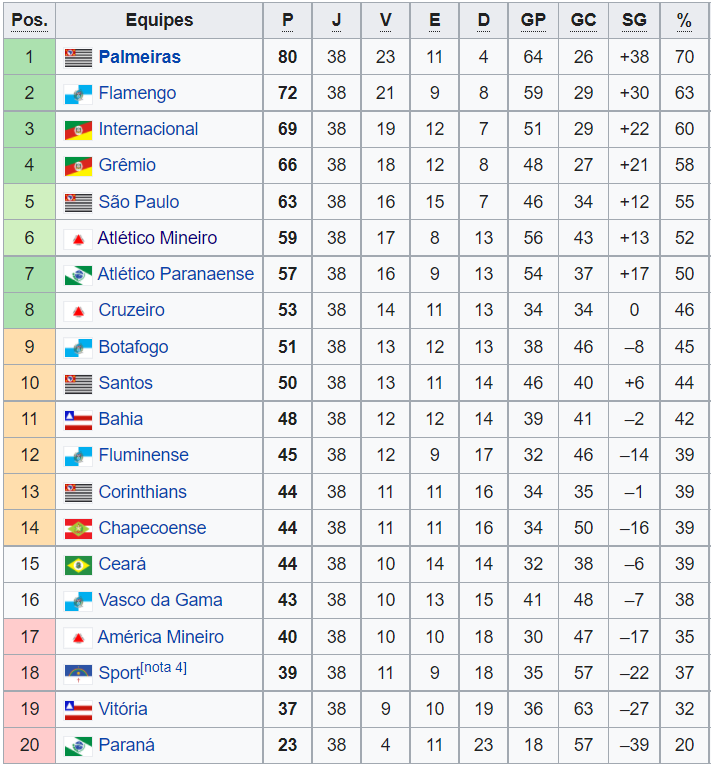

Observando o Brasileirão 2019 e verificando as pontuações esperadas de cada uma das equipes. Veja que a ordem as estimativas do classificador errou, porém dos 6 primeiros ele acertou 5 e dos 6 últimos ele acertou 4.

In [218]:
df_br2019 = df_teste[(df_teste['campeonato'] == 'Campeonato Brasileiro') & (df_teste['divisao'] == 1) & (df_teste['temporada'] == 2019)]

pd.DataFrame(3*df_br2019.groupby('mandante')['H'].sum() + 
             df_br2019.groupby('mandante')['D'].sum() + 
             3*df_br2019.groupby('visitante')['A'].sum() + 
             df_br2019.groupby('visitante')['D'].sum(), columns = ['pontos']).sort_values(by = 'pontos', ascending = False)

,pontos
mandante,
Palmeiras,61.223553
Flamengo,60.896953
Internacional,57.739477
Athletico-PR,55.372605
Santos,55.317026
Gremio,54.988513
Corinthians,53.613329
Atletico-MG,53.560192
Cruzeiro,52.600198


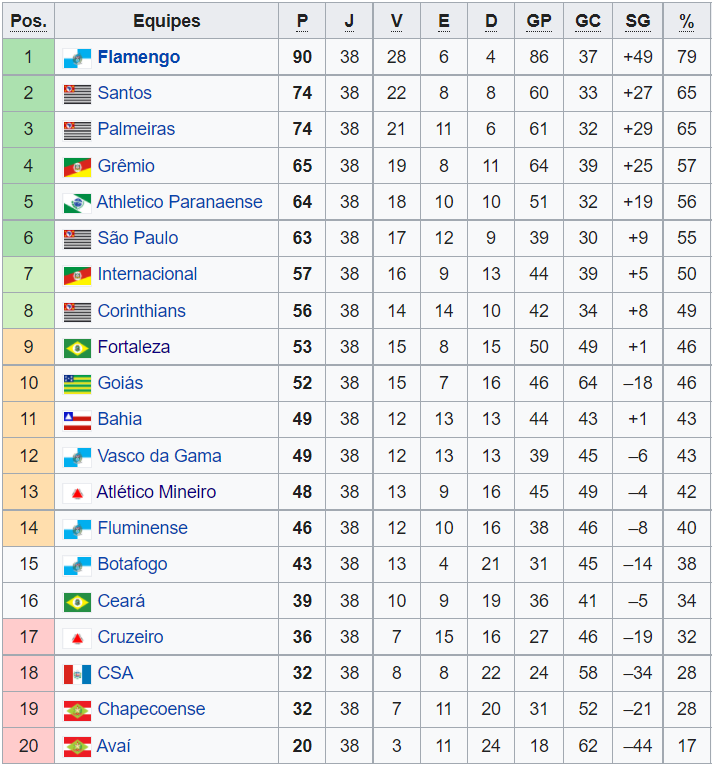

### **Conclusão**

Vimos nesse trabalho como é a tarefa ingrata de estimar resultados em futebol. Geralmente, antes da partida há muito poucas informações que nos levam a estimar com clareza o resultado final. Treinamos vários classificadores com diferentes hiperparâmetros para tentar chegar em um classificador com problemas mas que servisse para ajudar a estimar o desempenho das equipes. Escolhi o classificador Random Forest com peso balanceado nas classes, com profundidade máxima igual a 10 e com 50 estimadores. Esse classificador estima muitas das probabilidades antes das partidas em torno de 20% a 40%, ou seja, não dá muitos indícios de quem pode ser o vencedor antes do jogo. Assim como deve ser já que antes da partida é muito difícil dizer quem pode vencer.

Acredito que esse trabalho cumpriu seu papel de desenvolver classificadores em um problema complexo e aplicou vários dos conceitos que vimos em sala de aula. O objetivo secundário também foi cumprido, vimos que das variáveis medidas antes do jogo as que representam o histórico das equipes são as que mais ajudam a dar alguma informação sobre a partida. 